In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


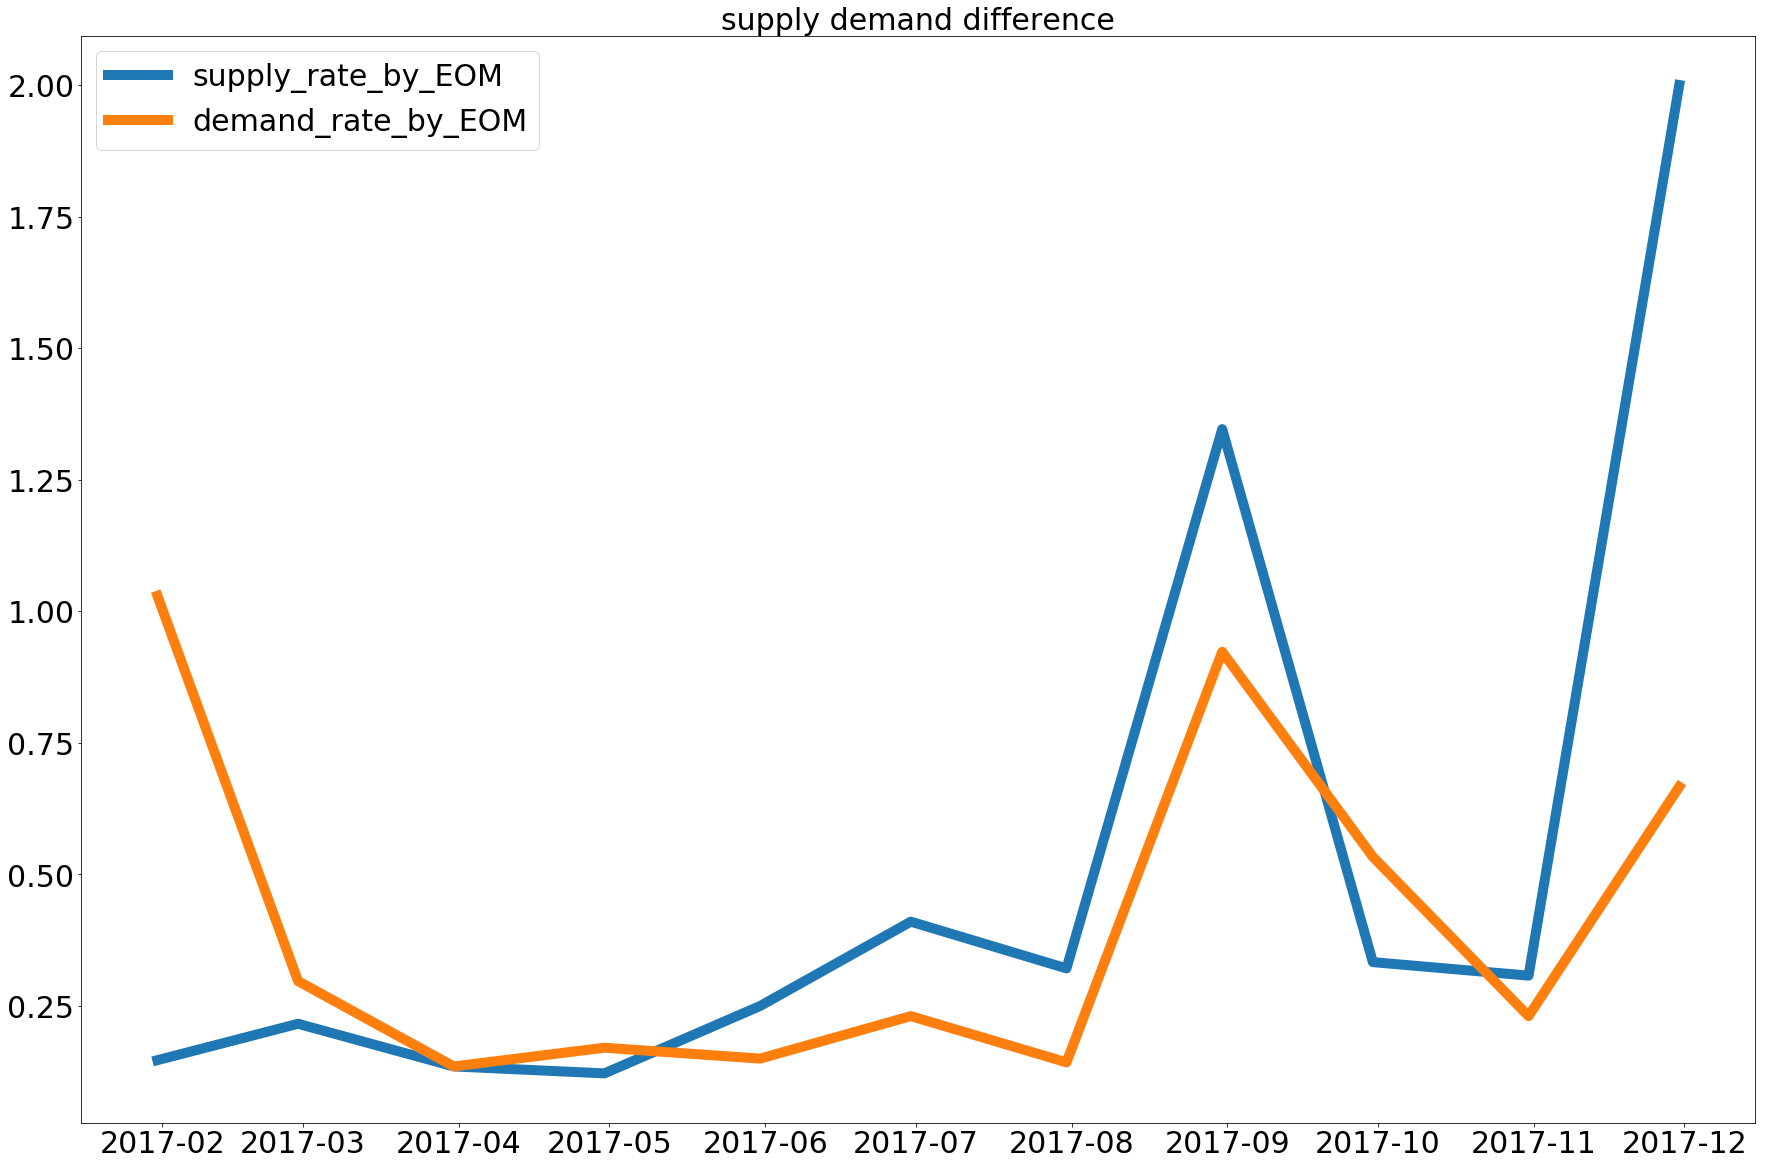

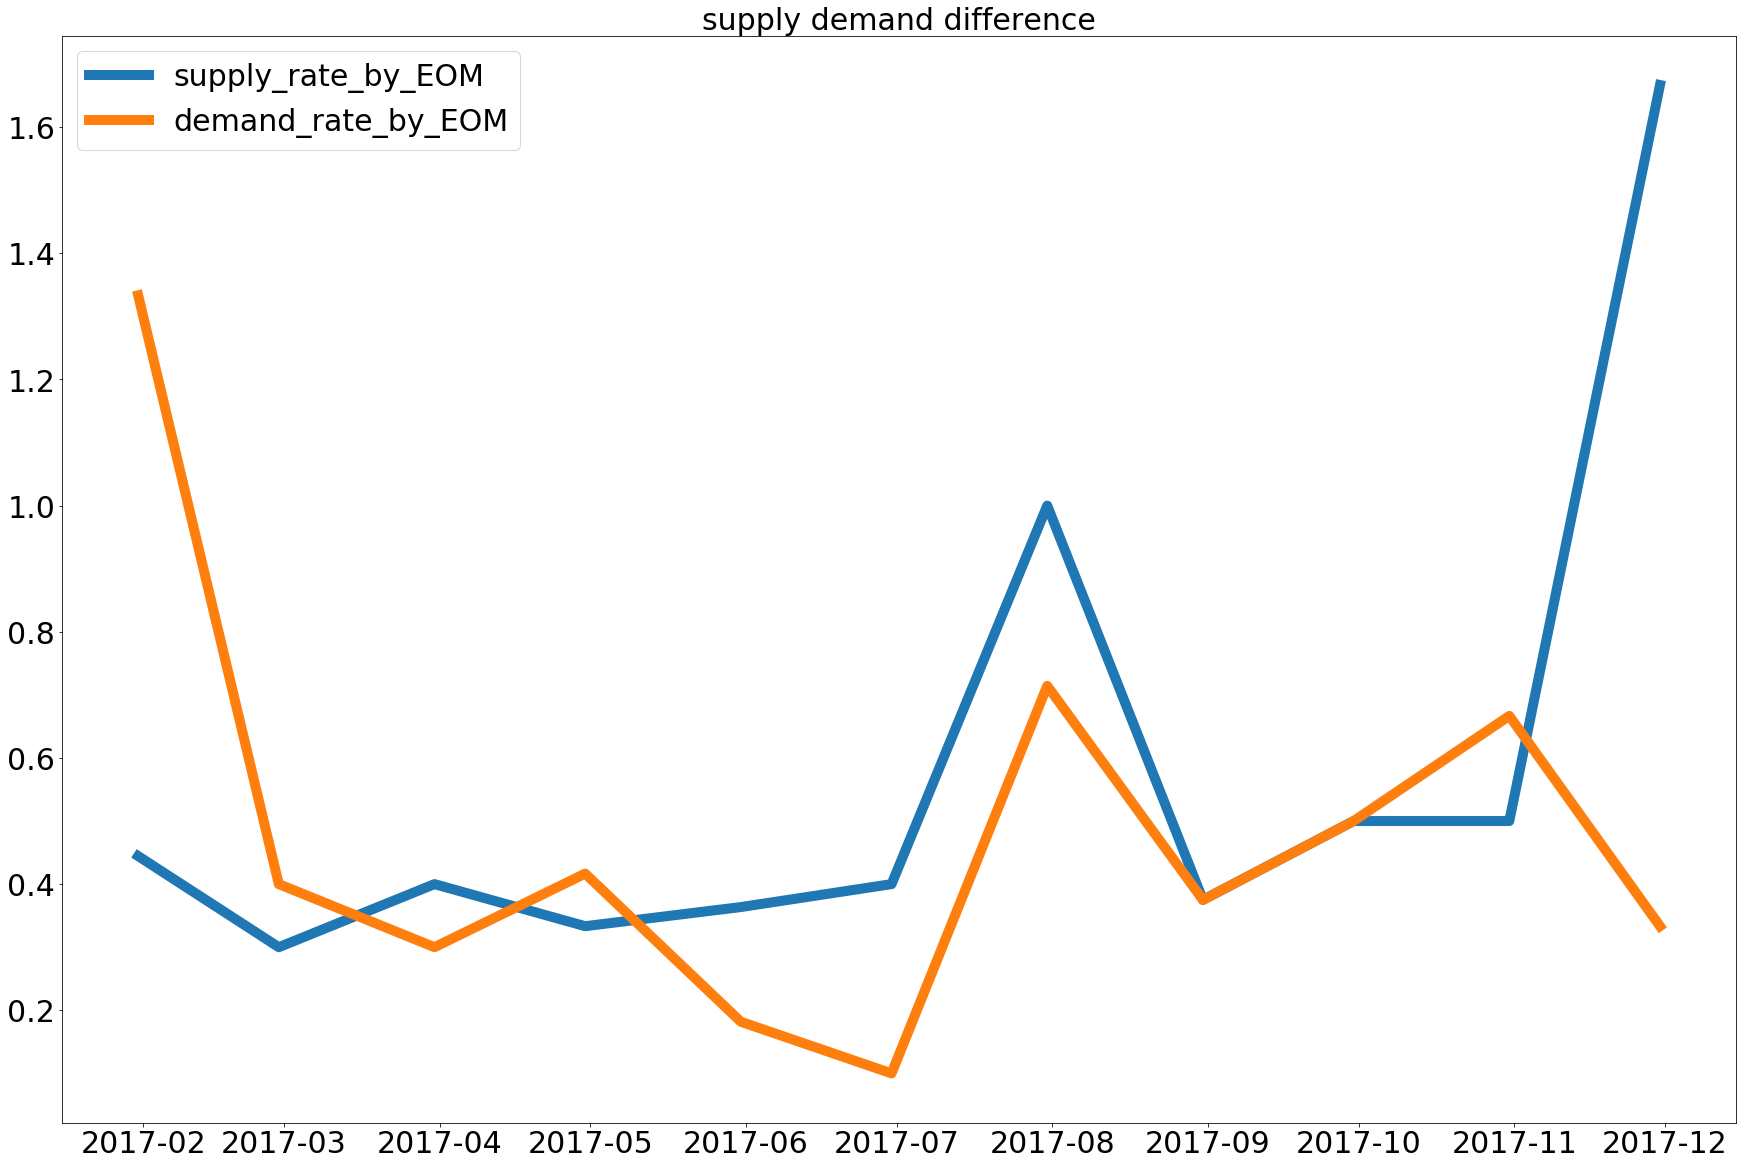

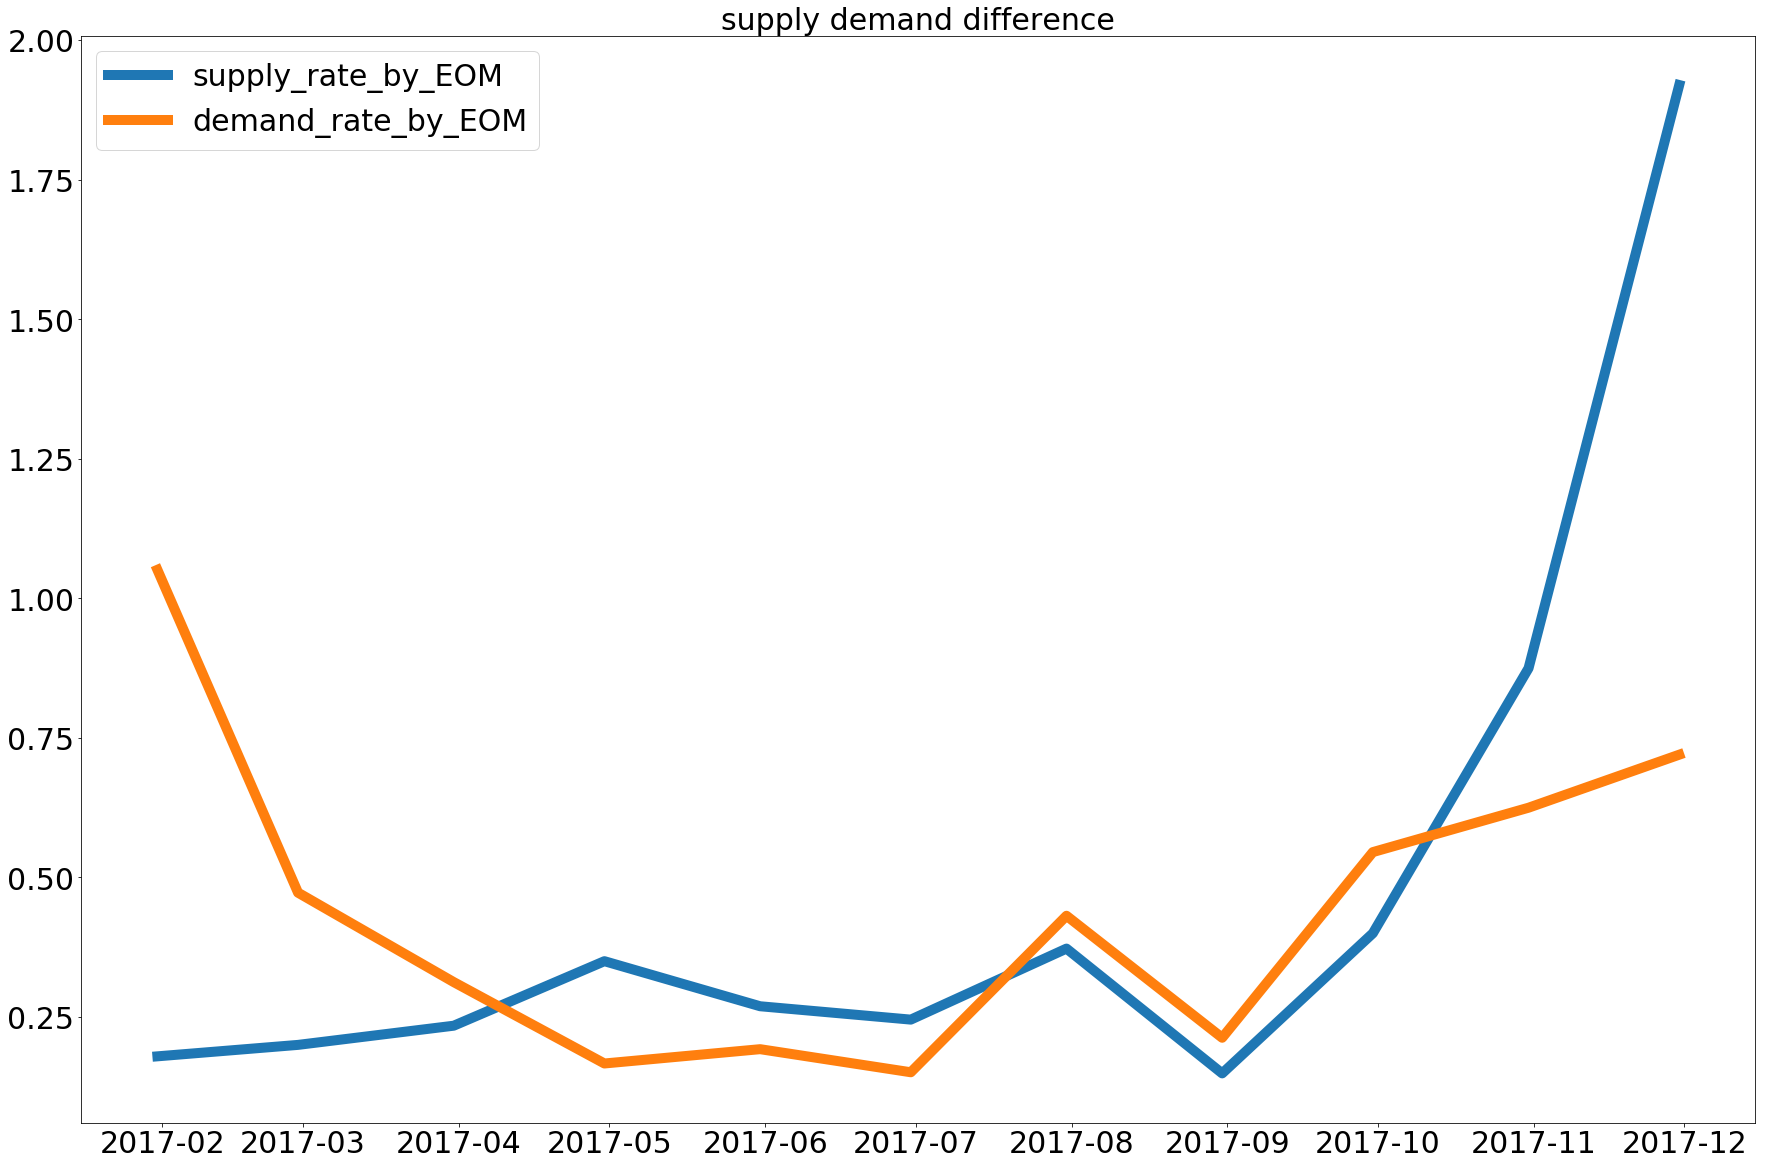

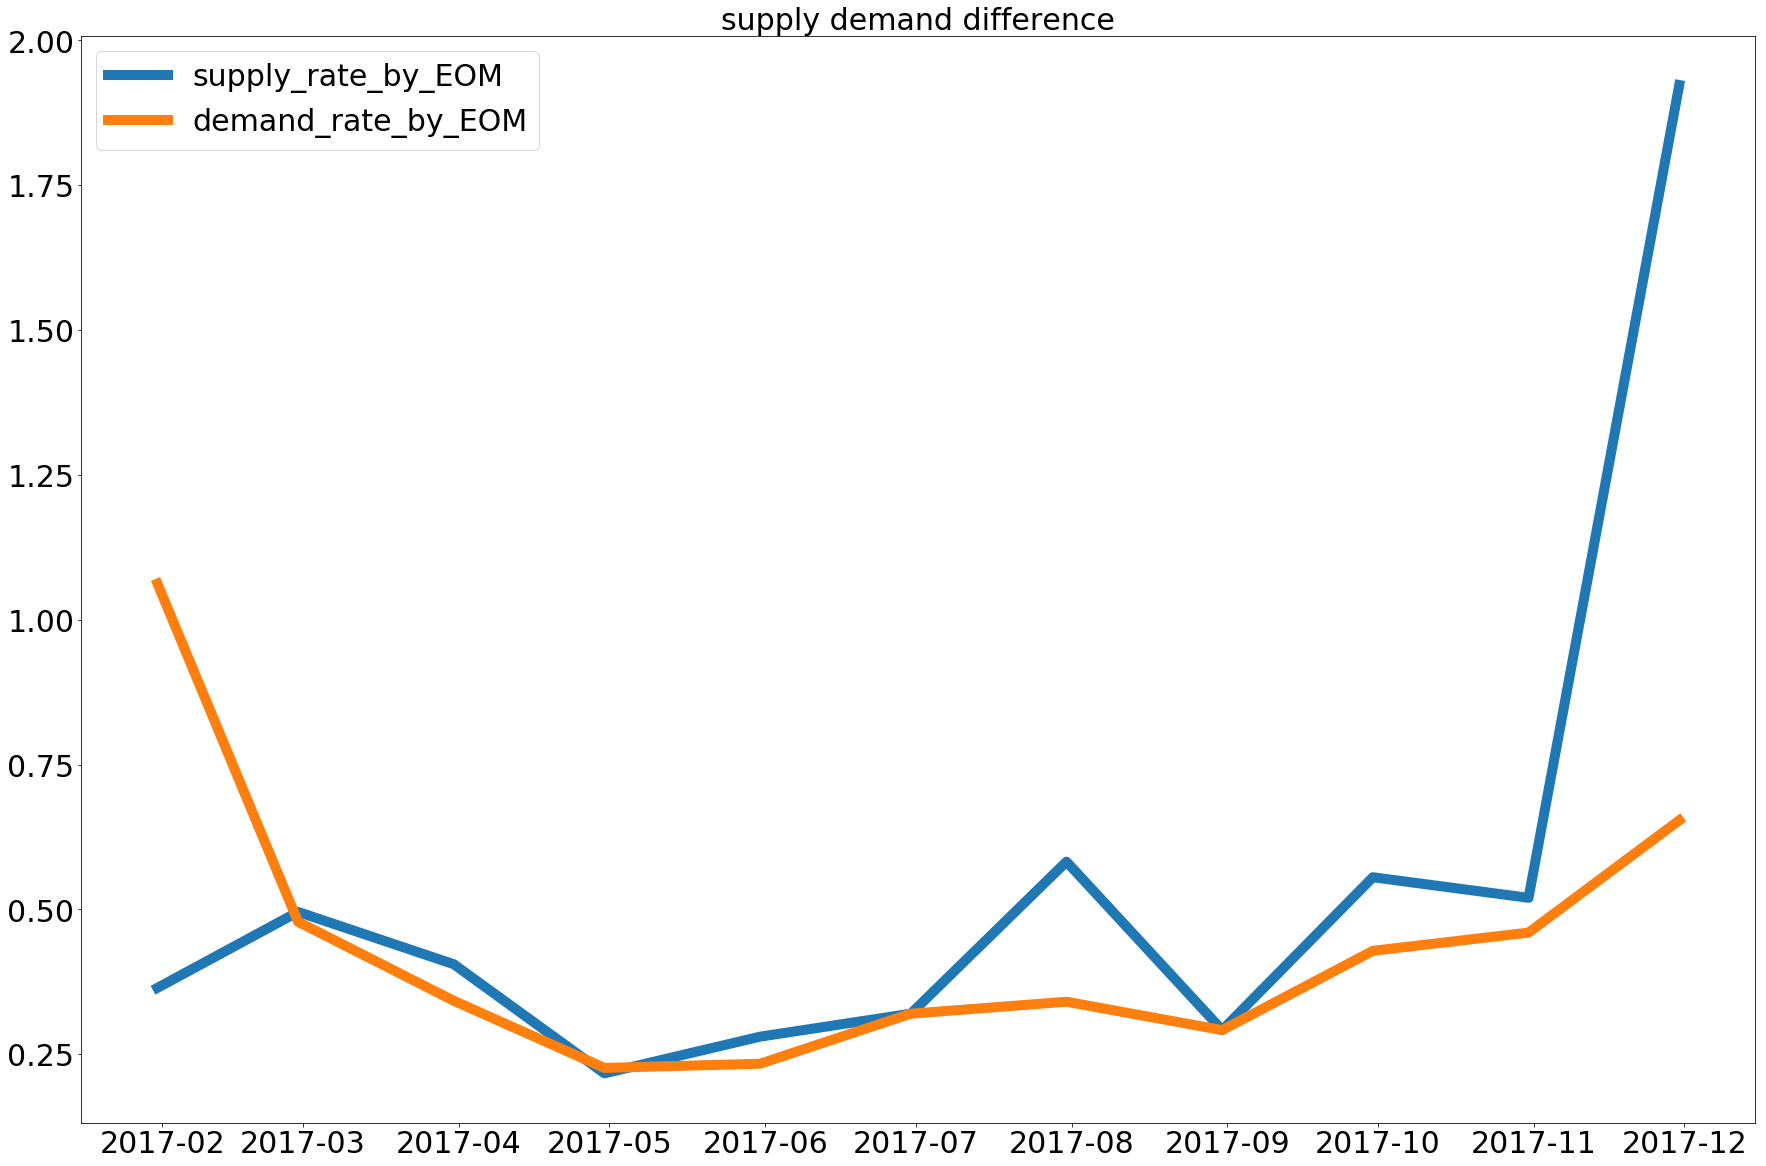

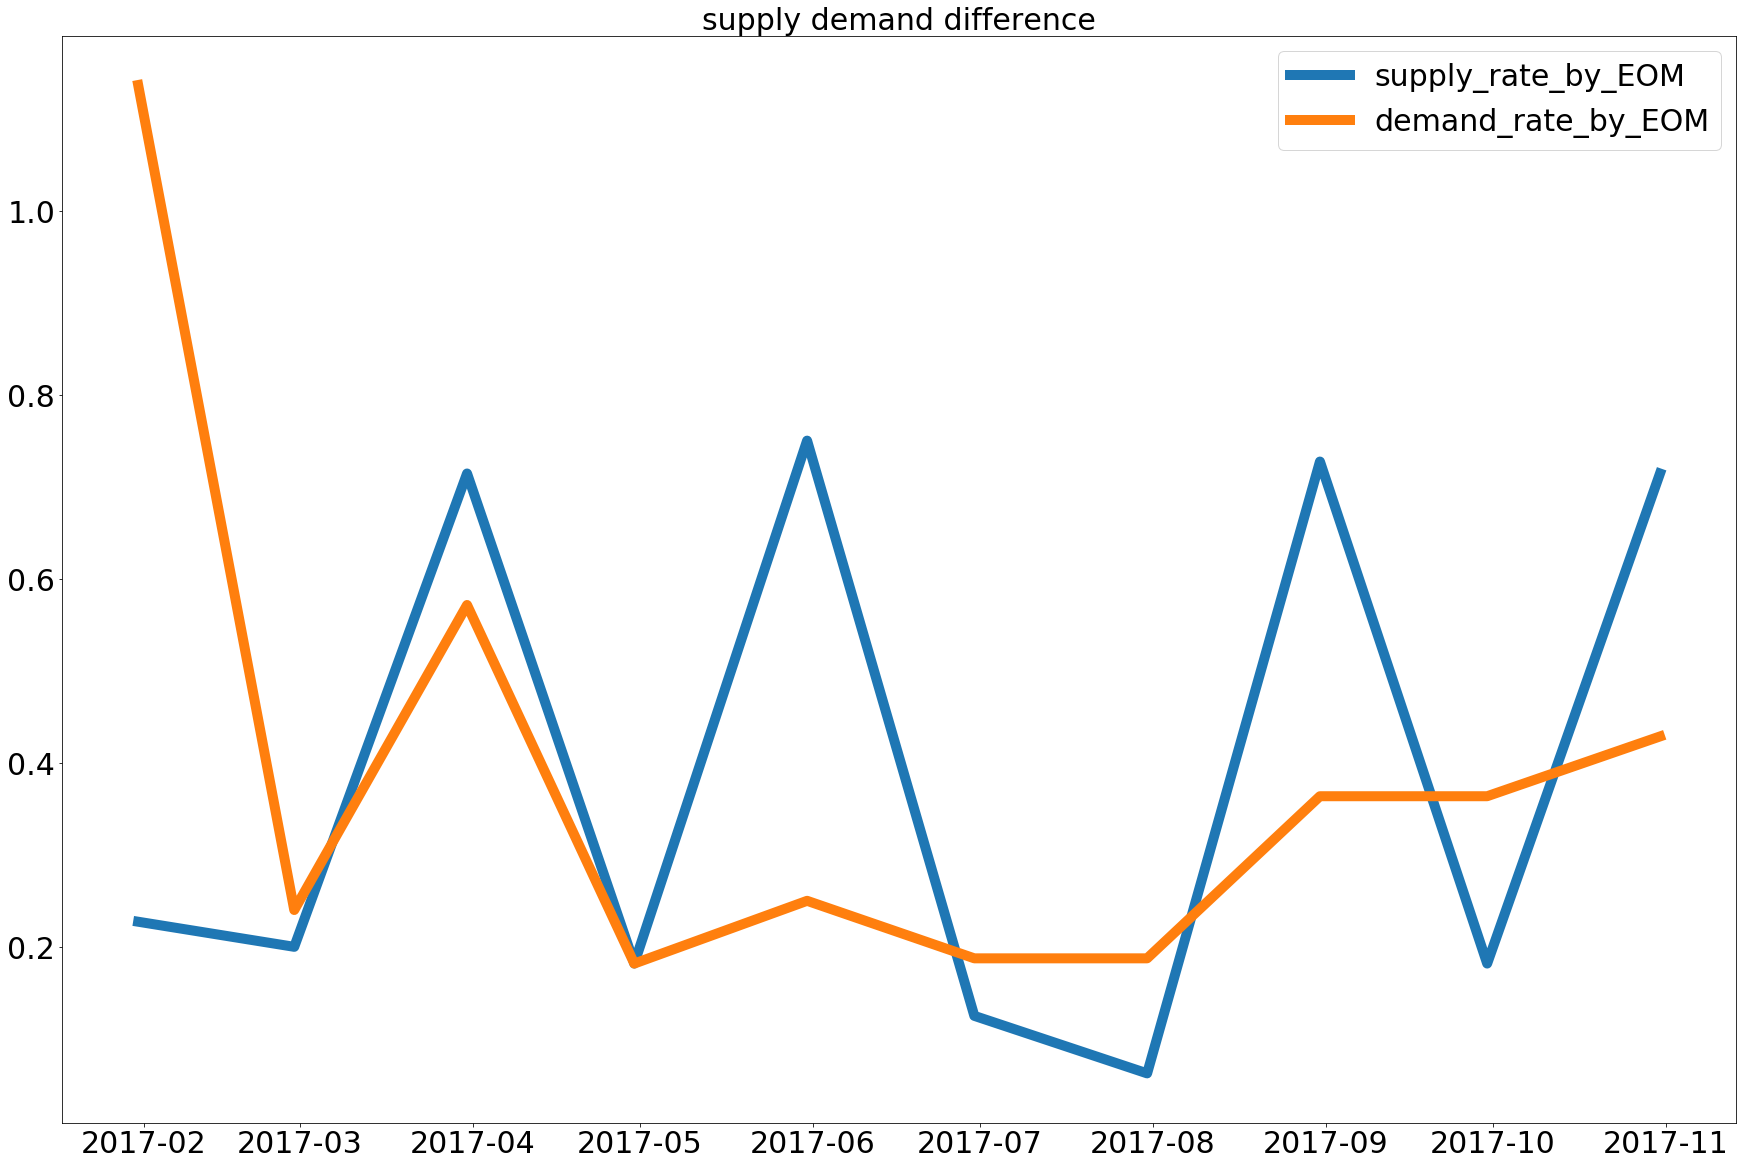

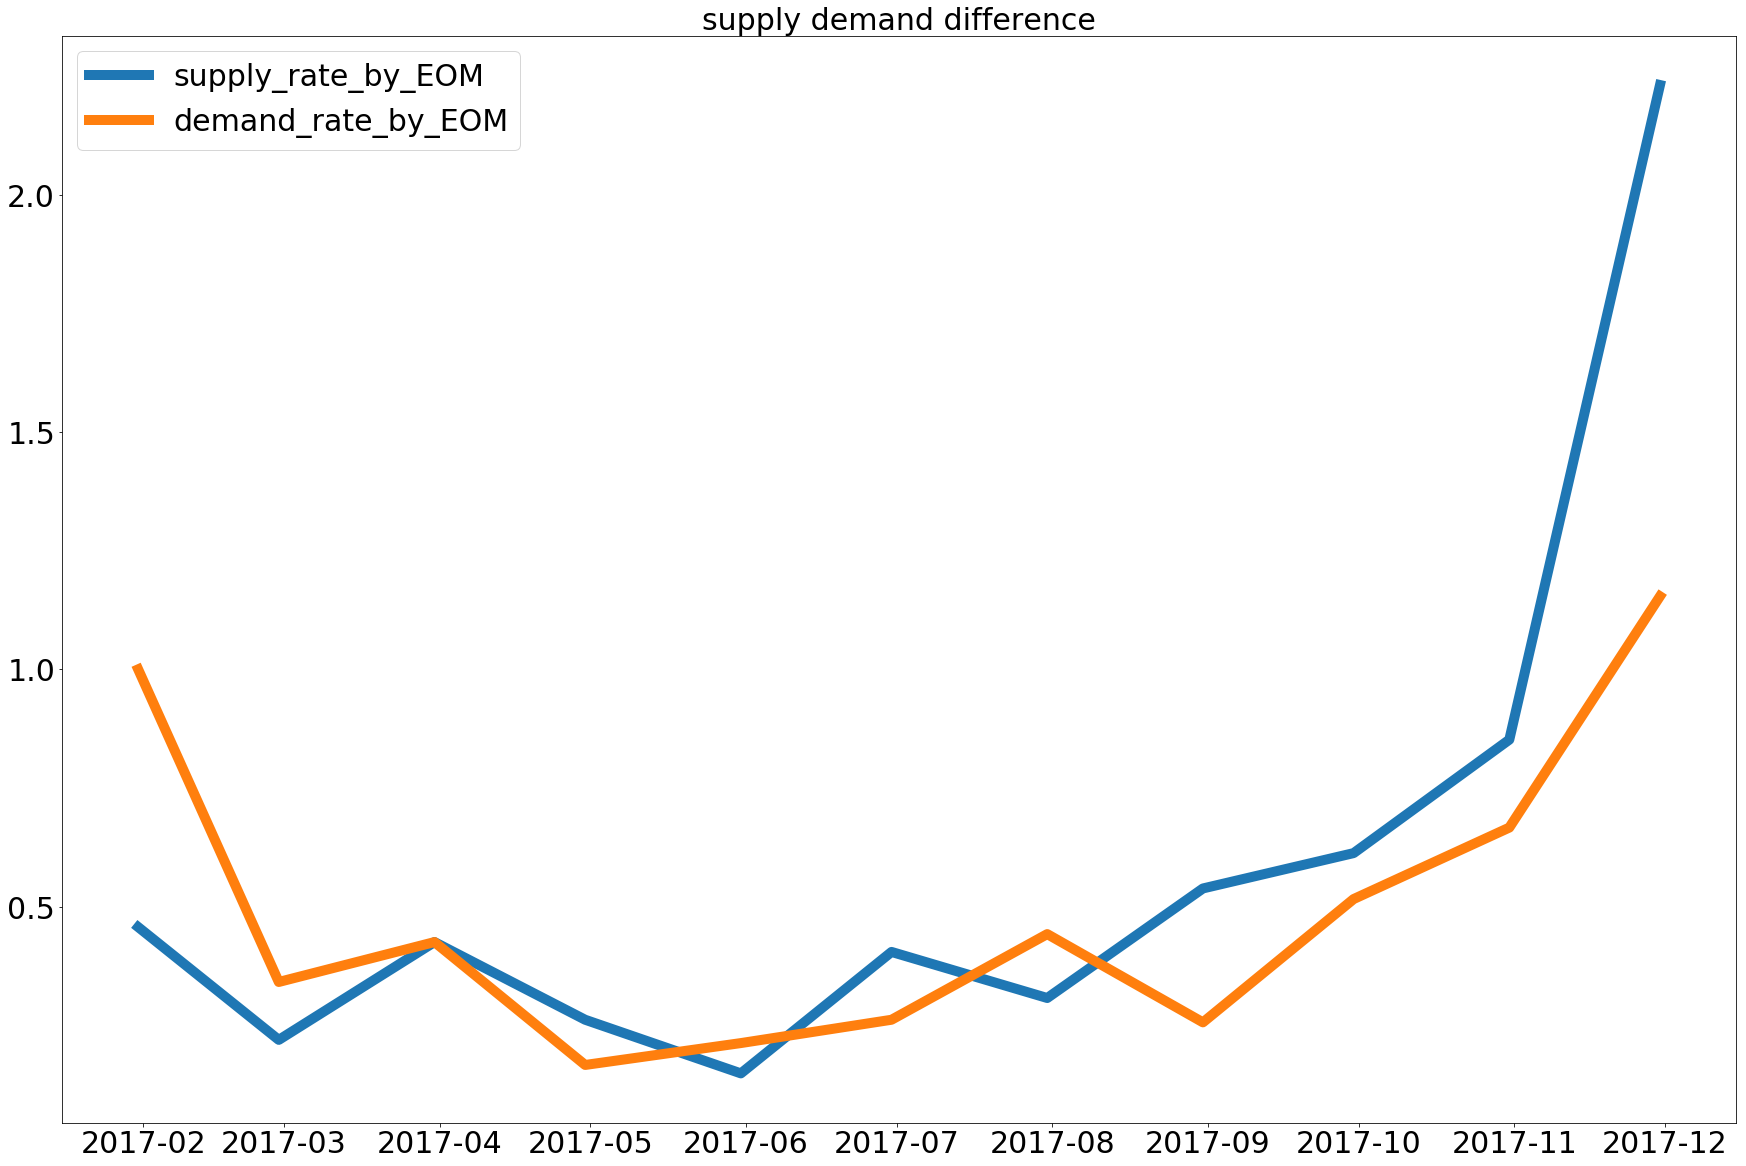

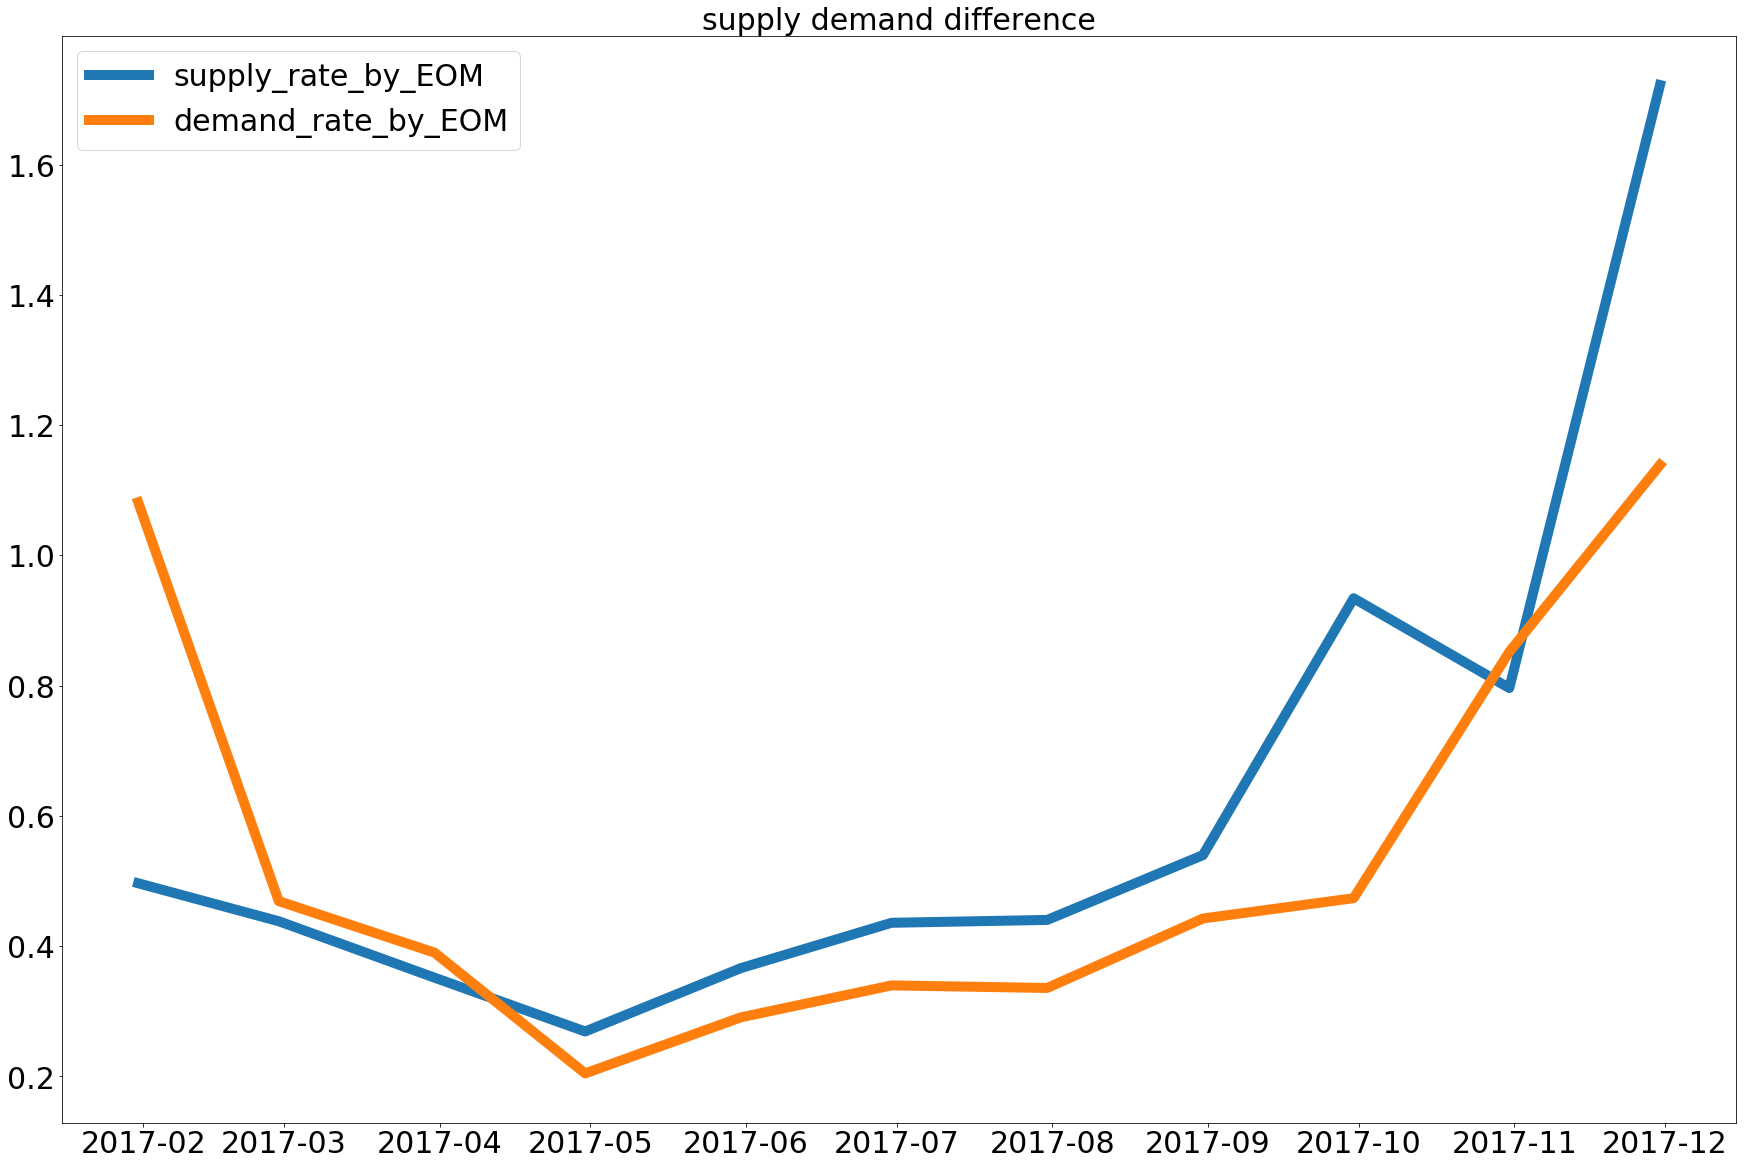

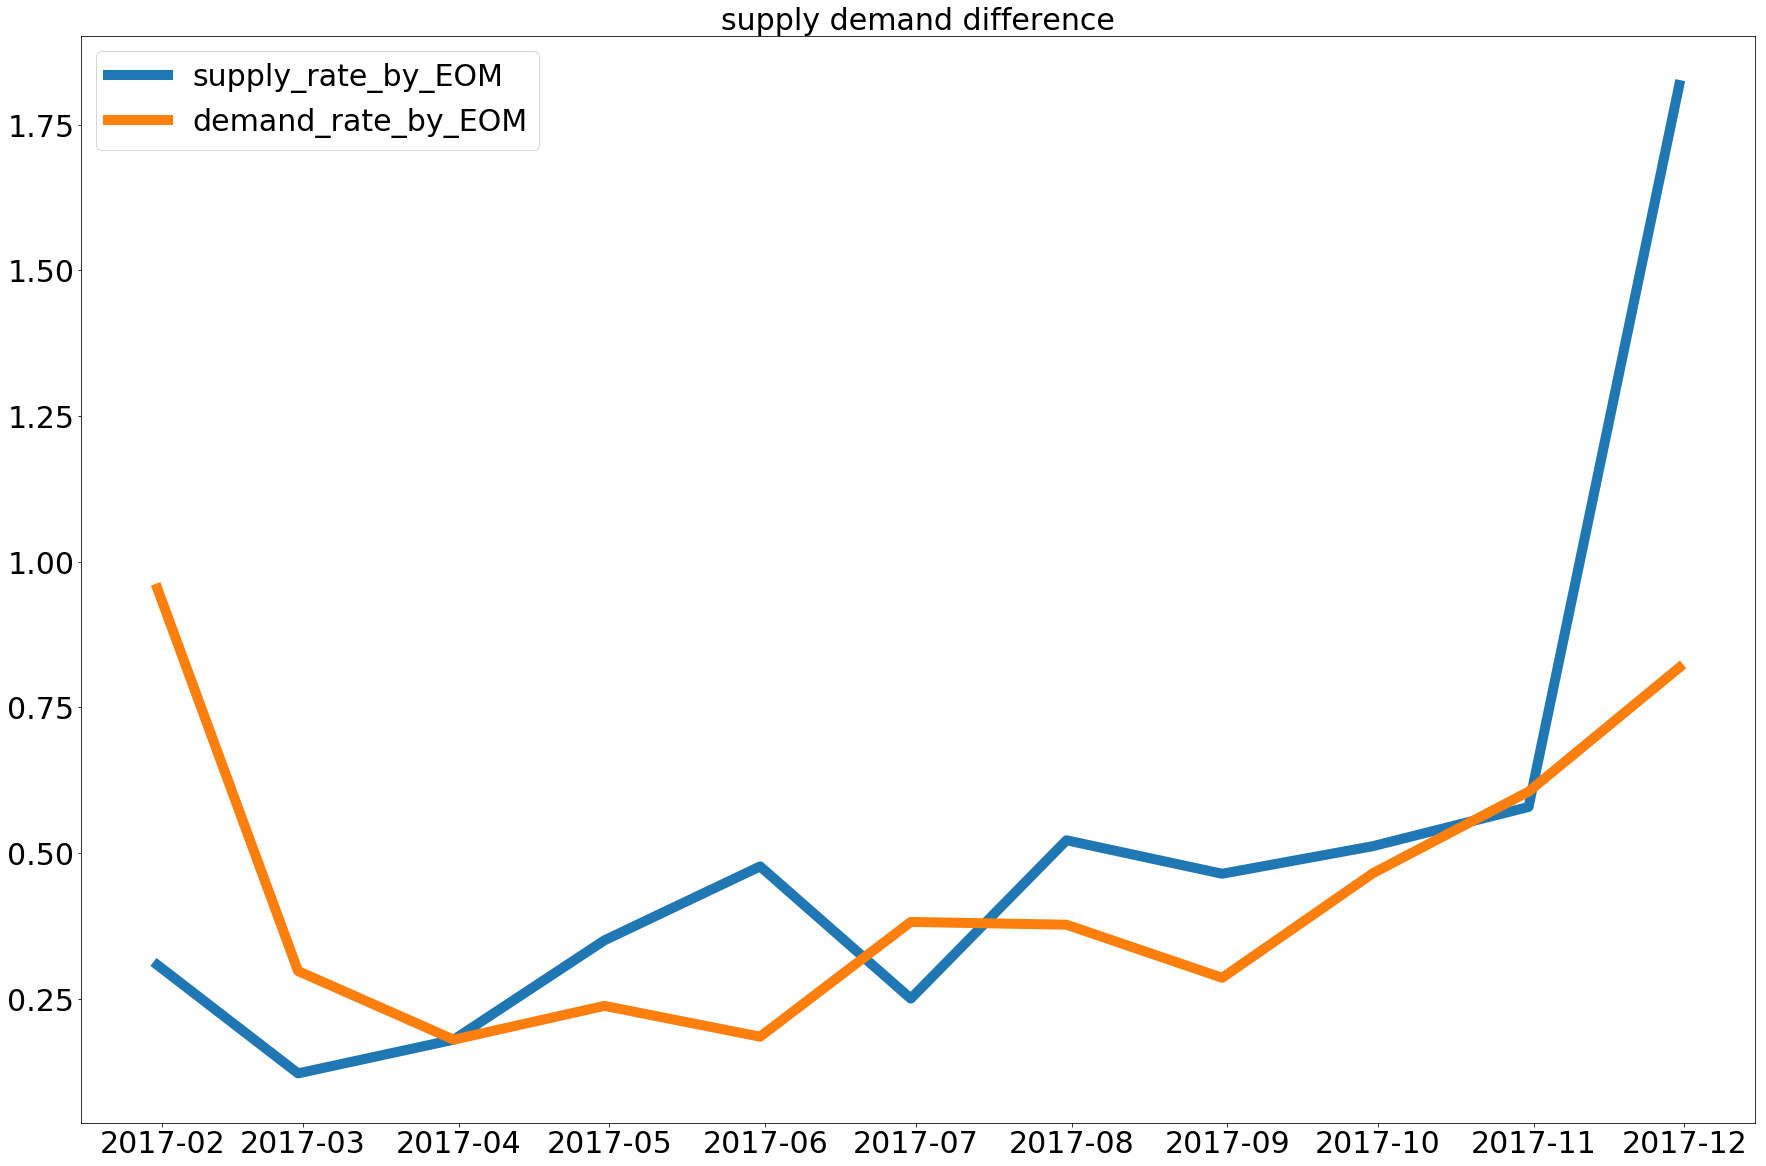

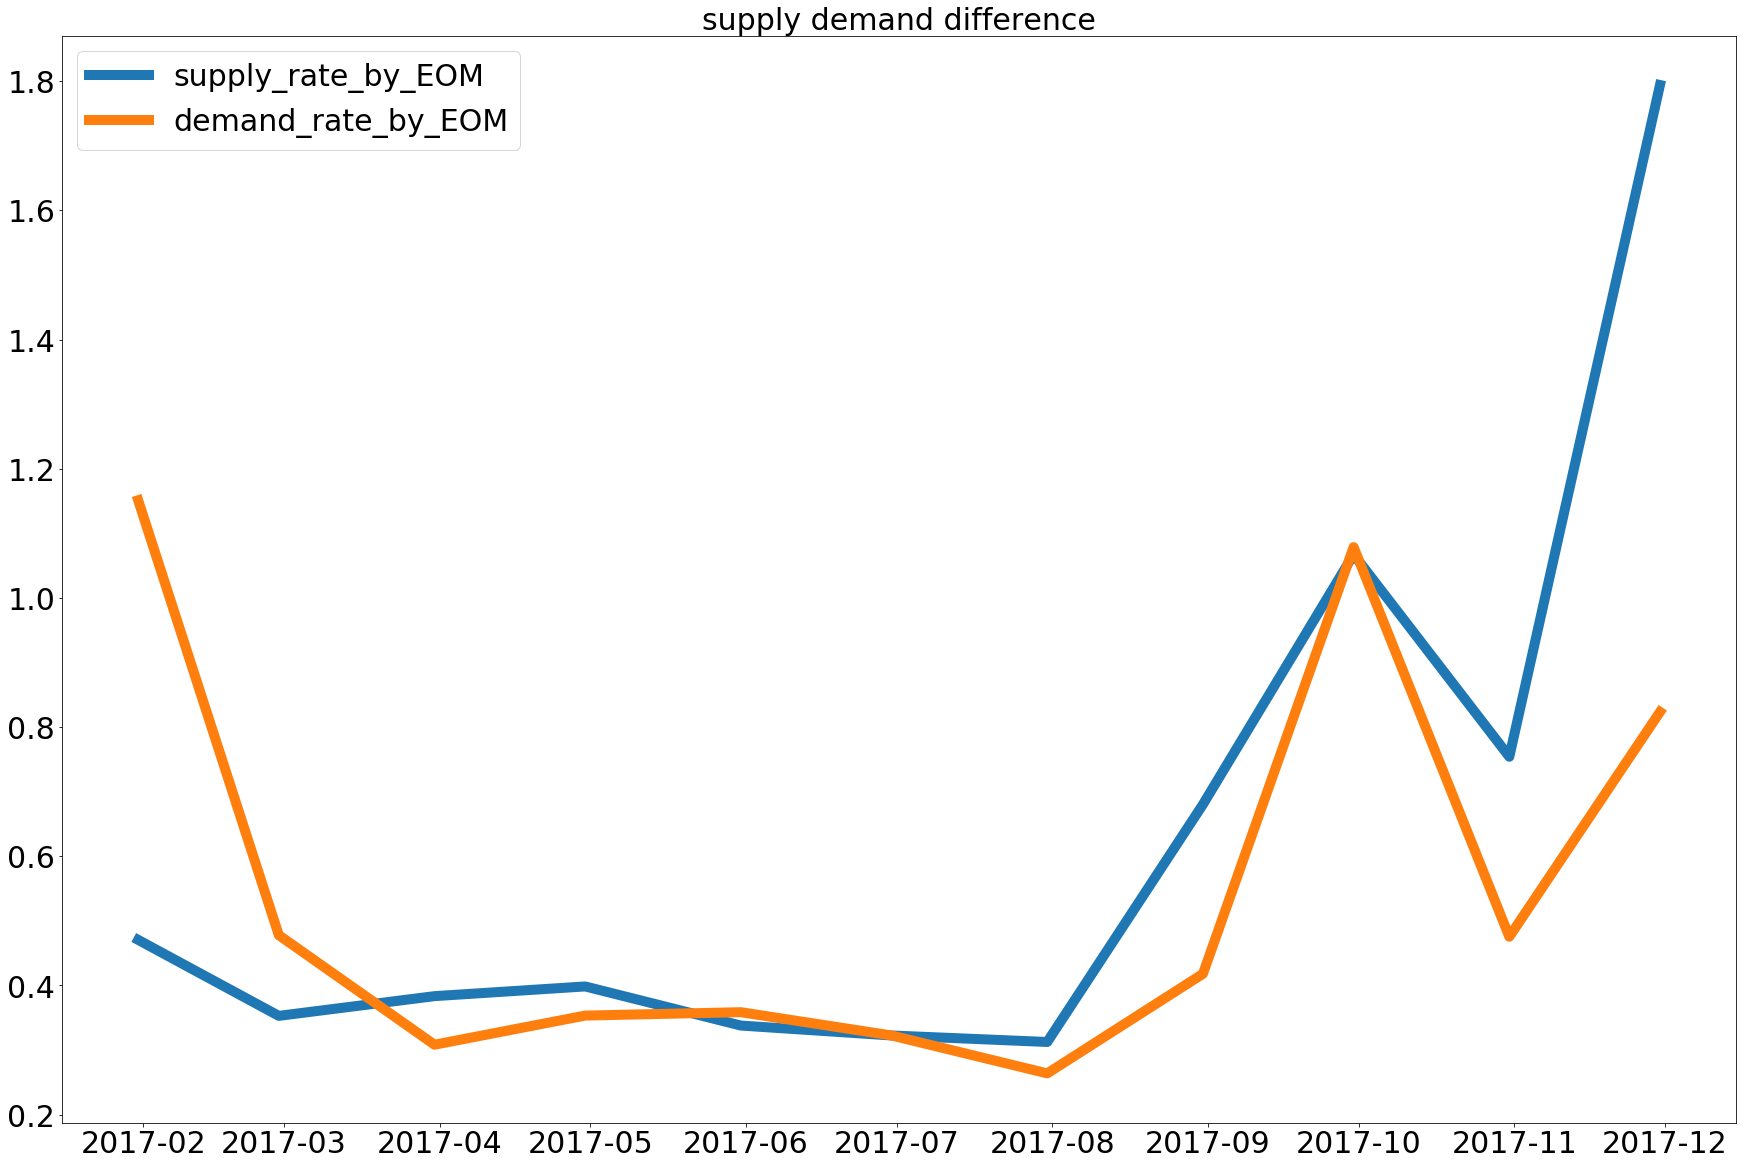

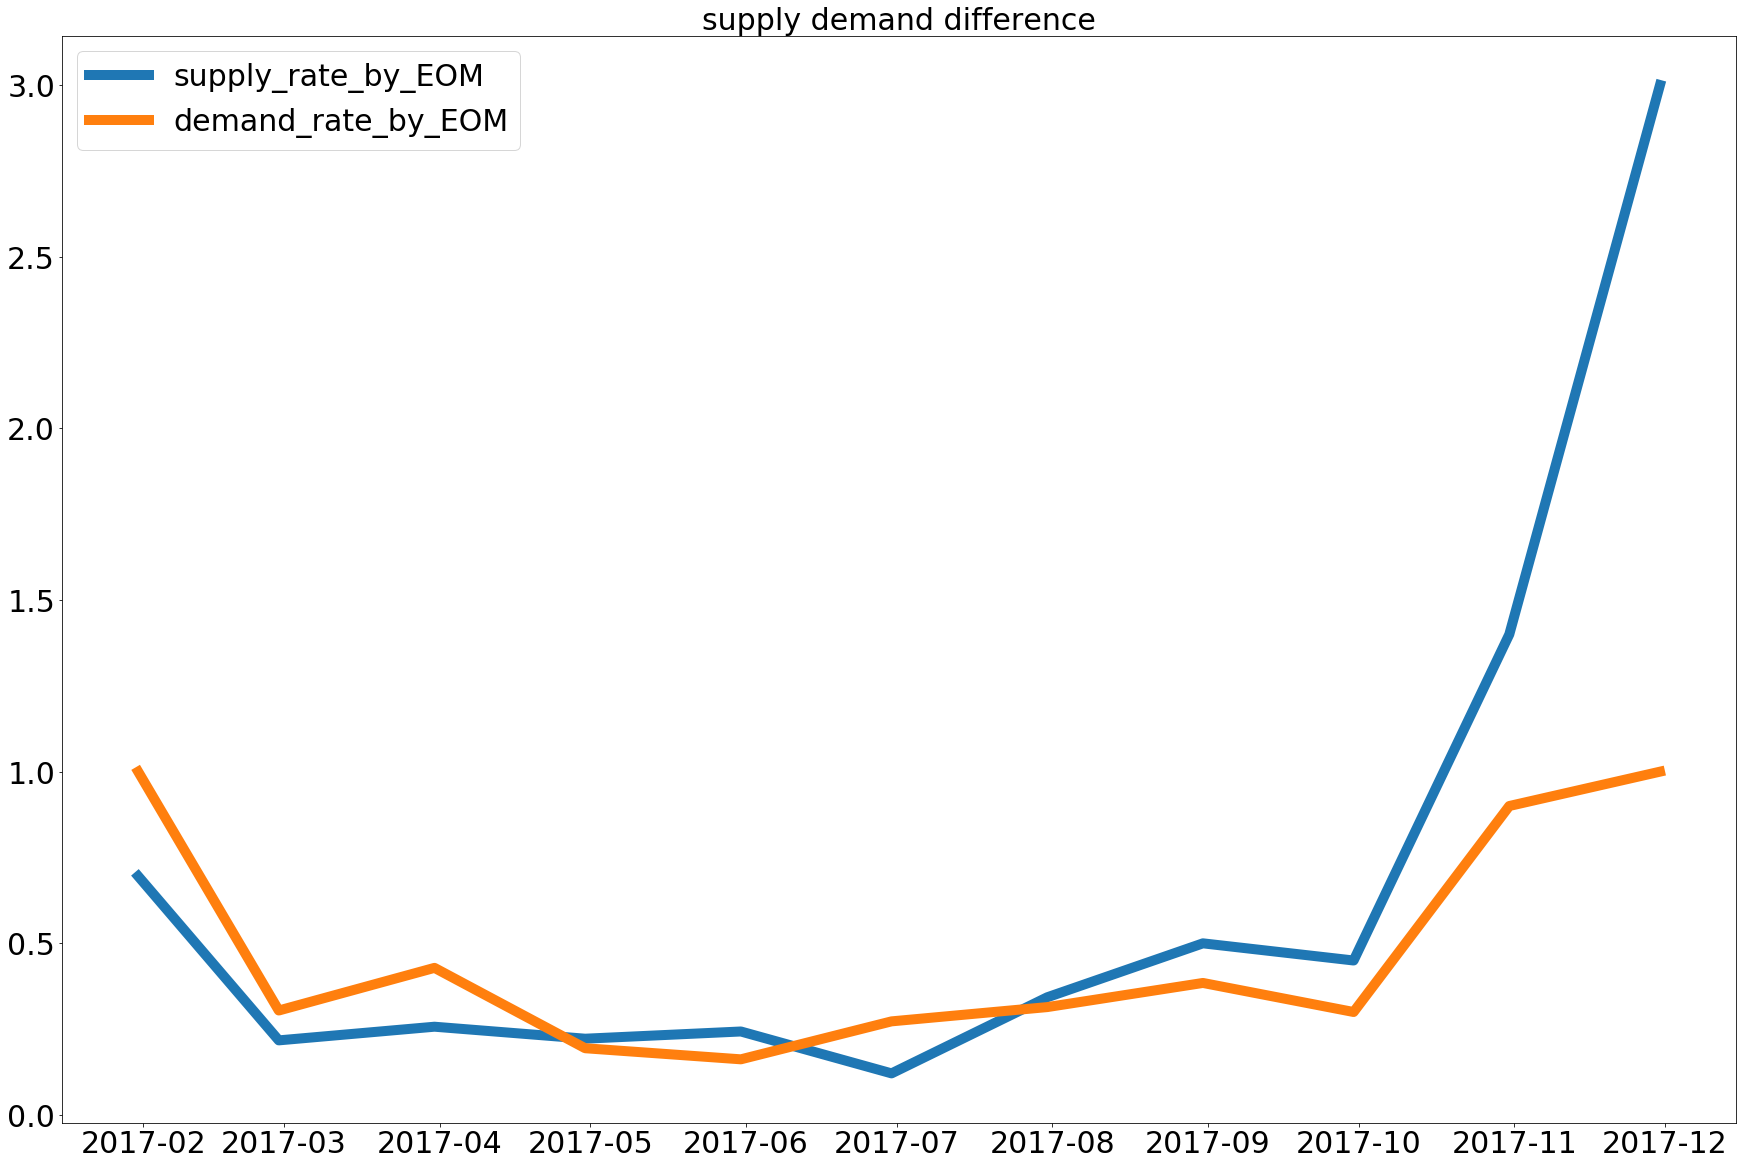

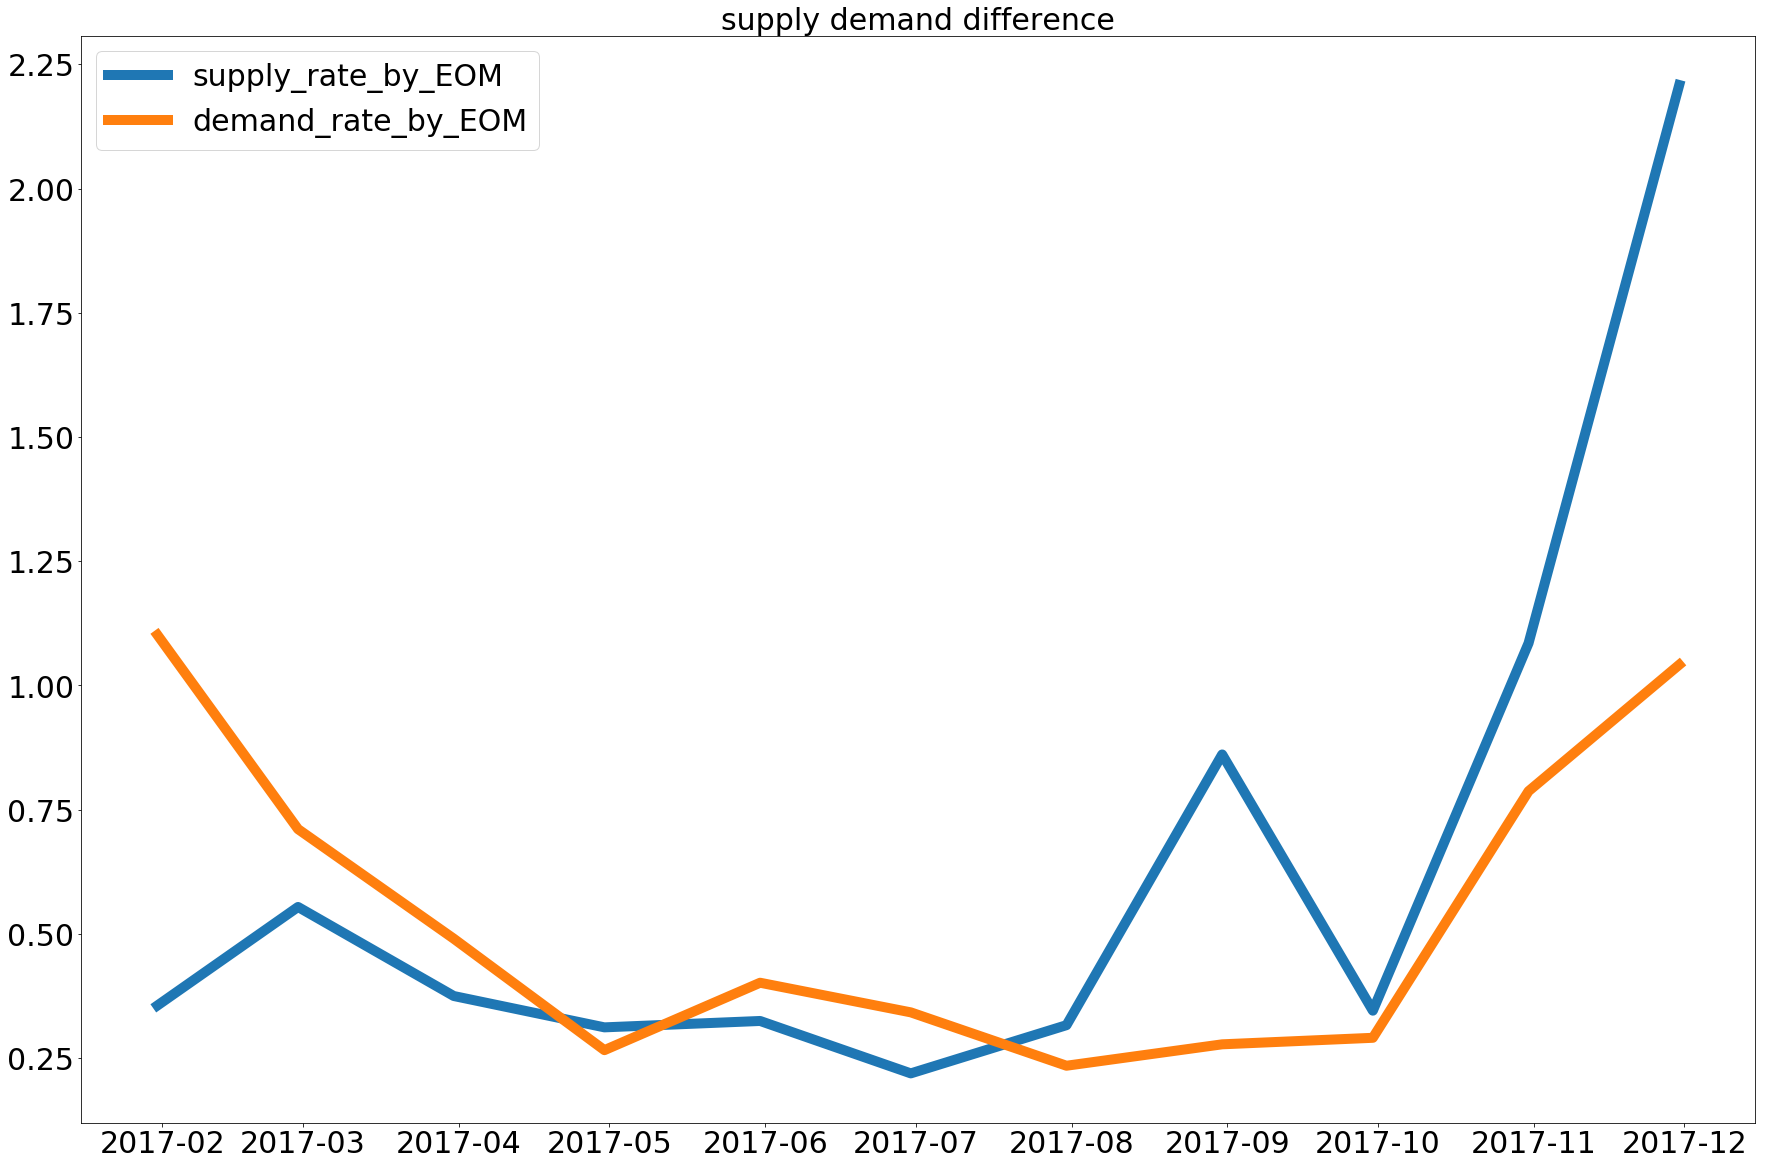

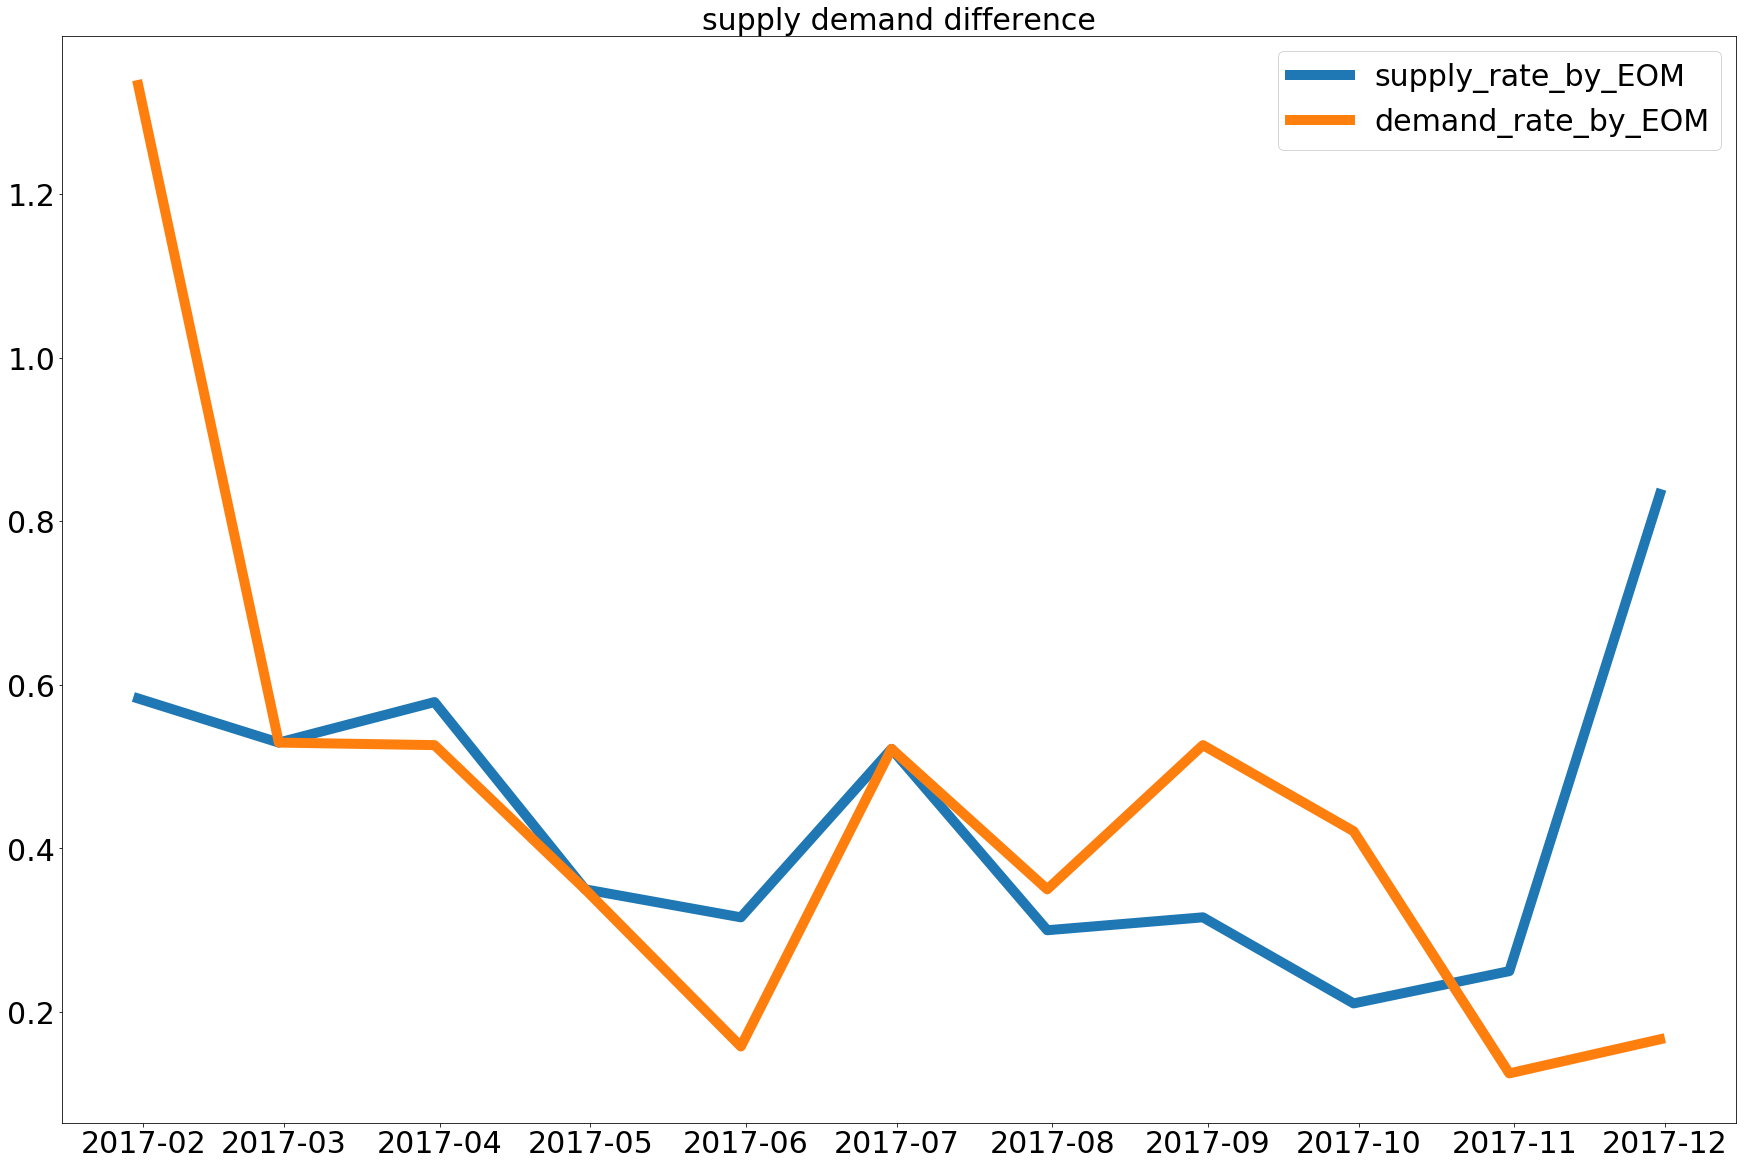

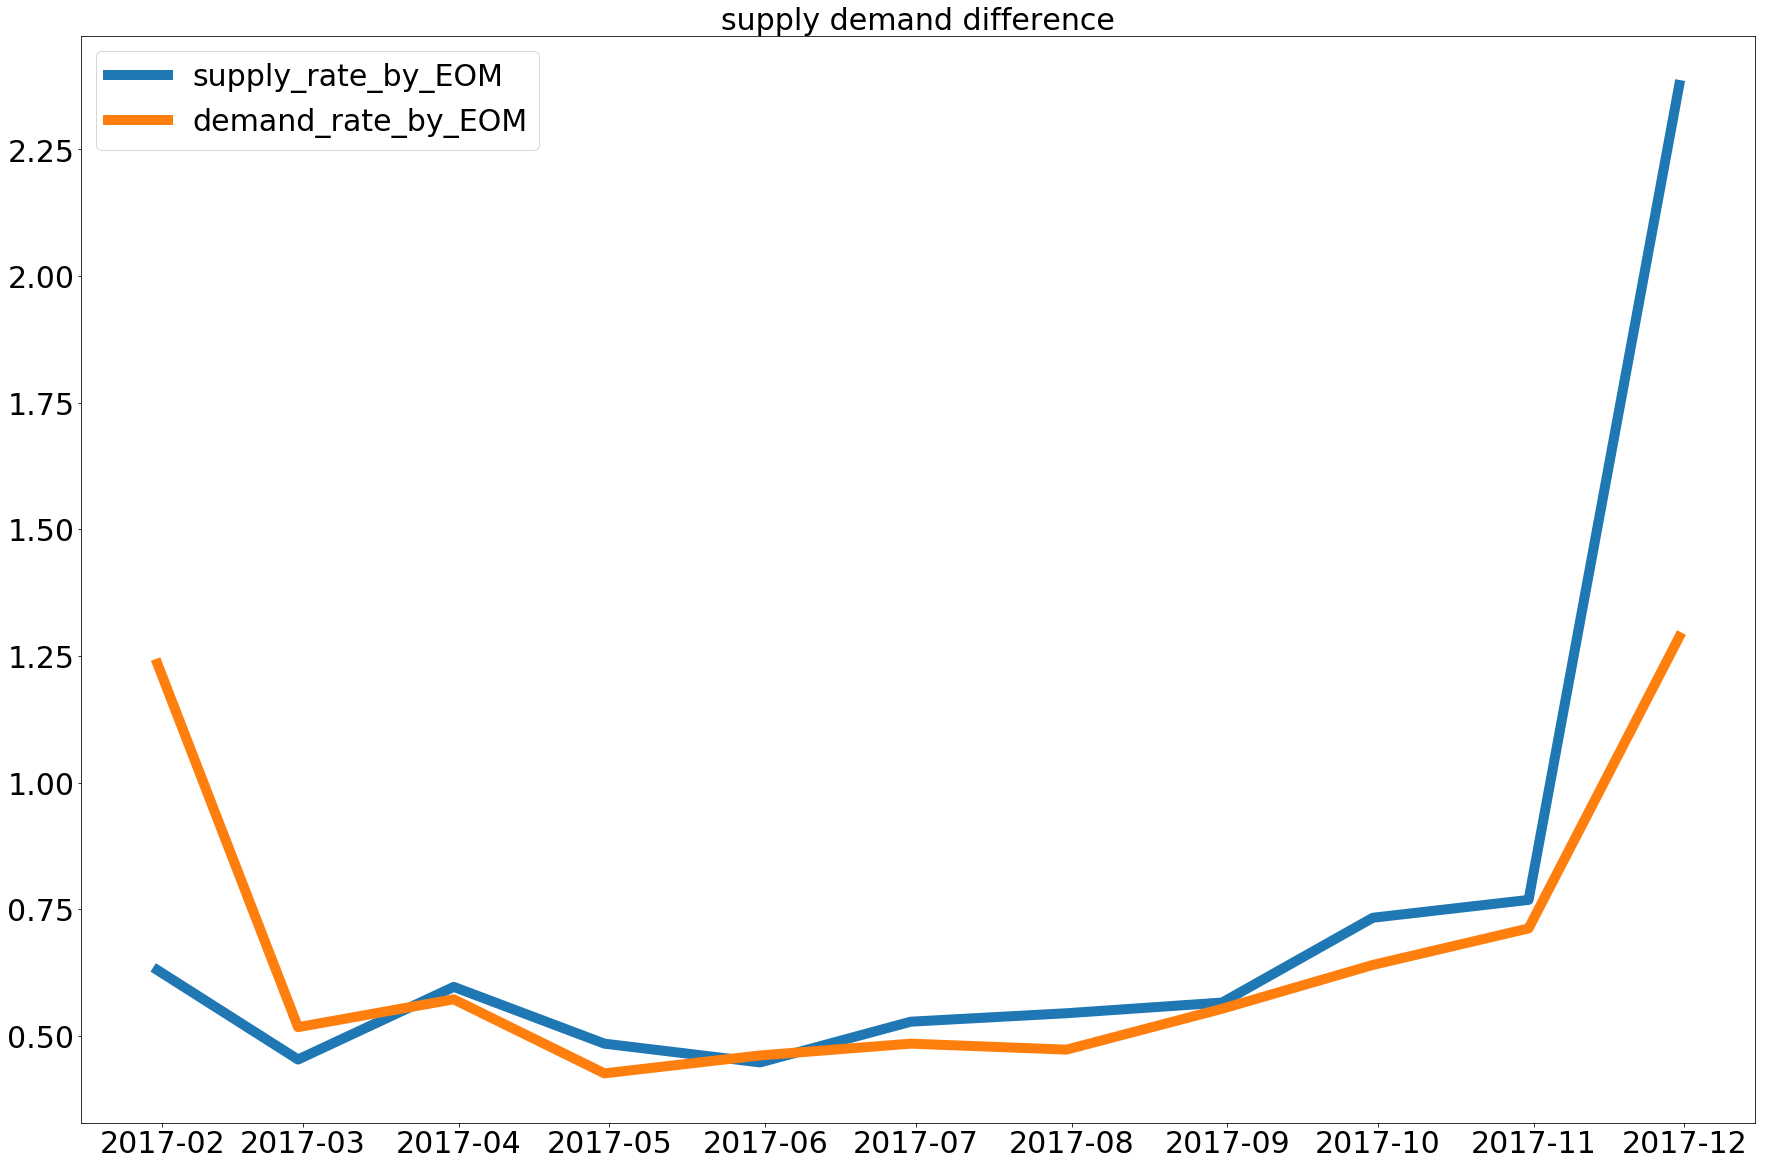

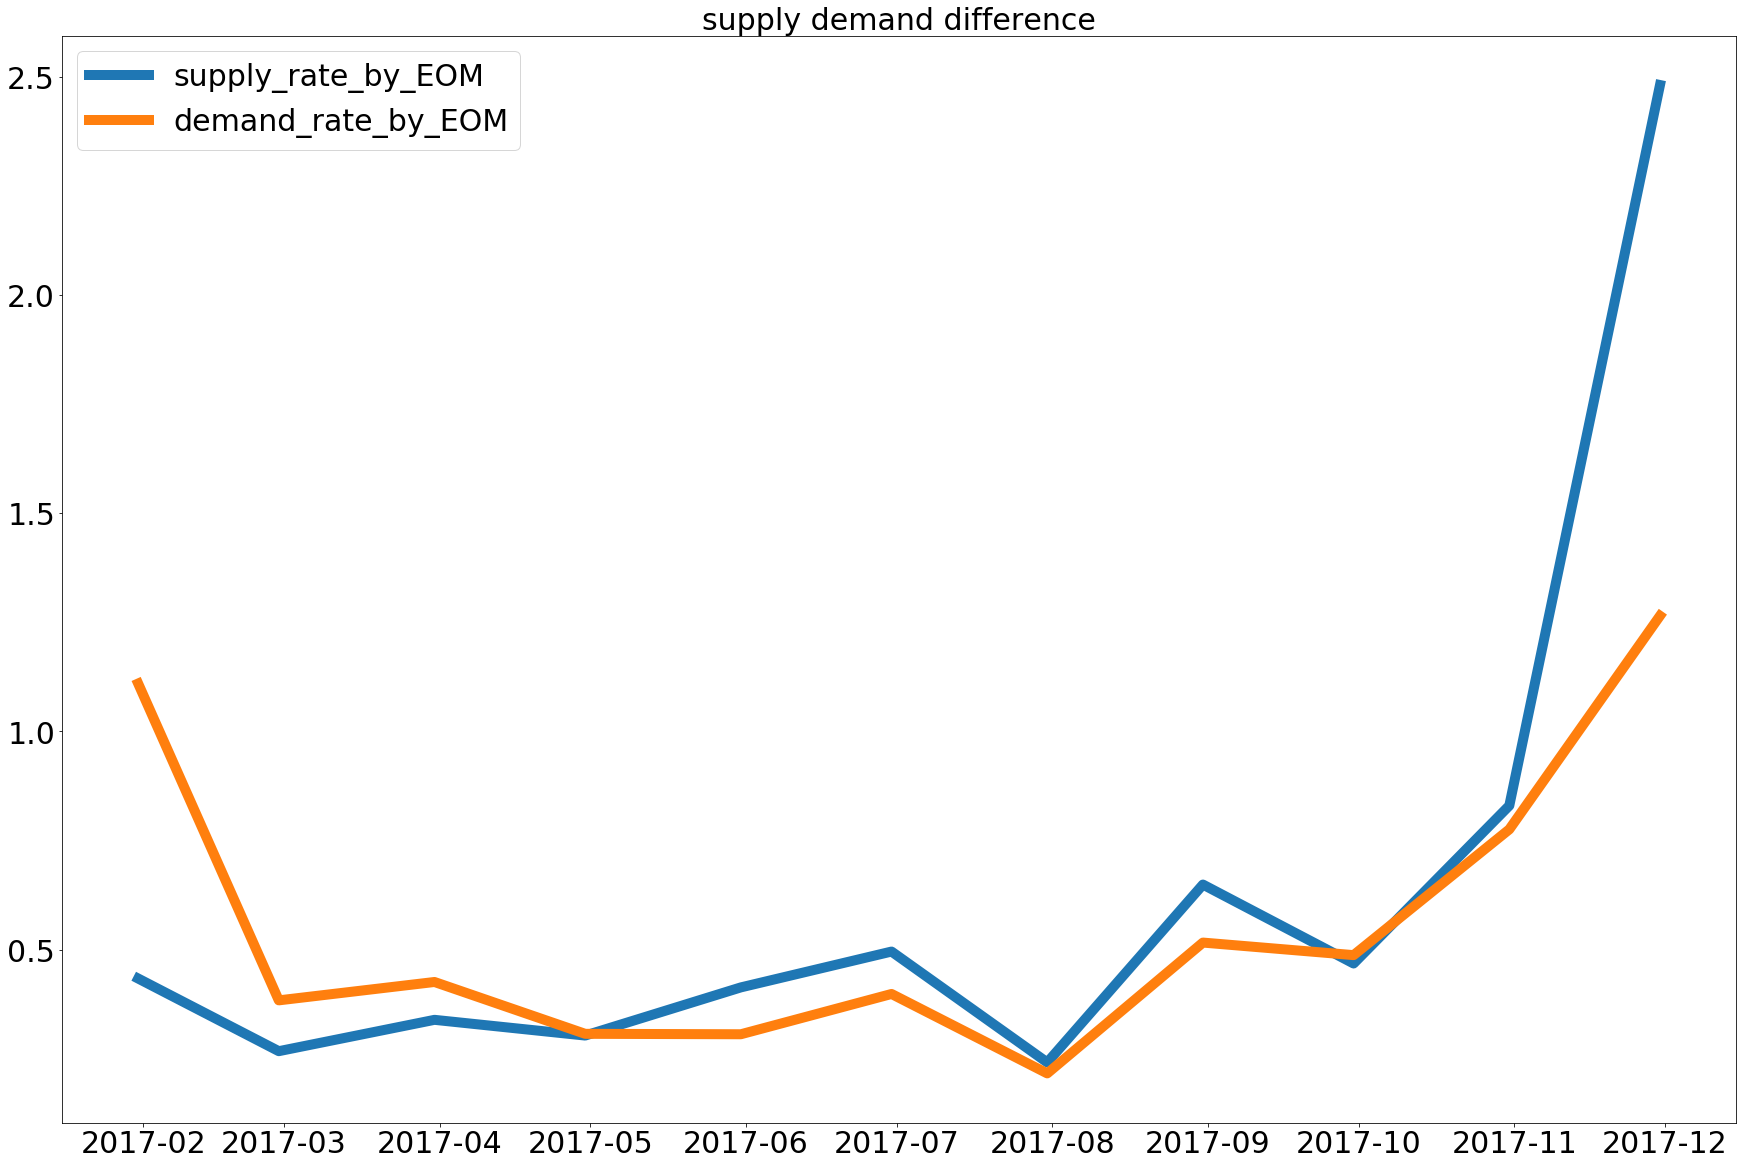

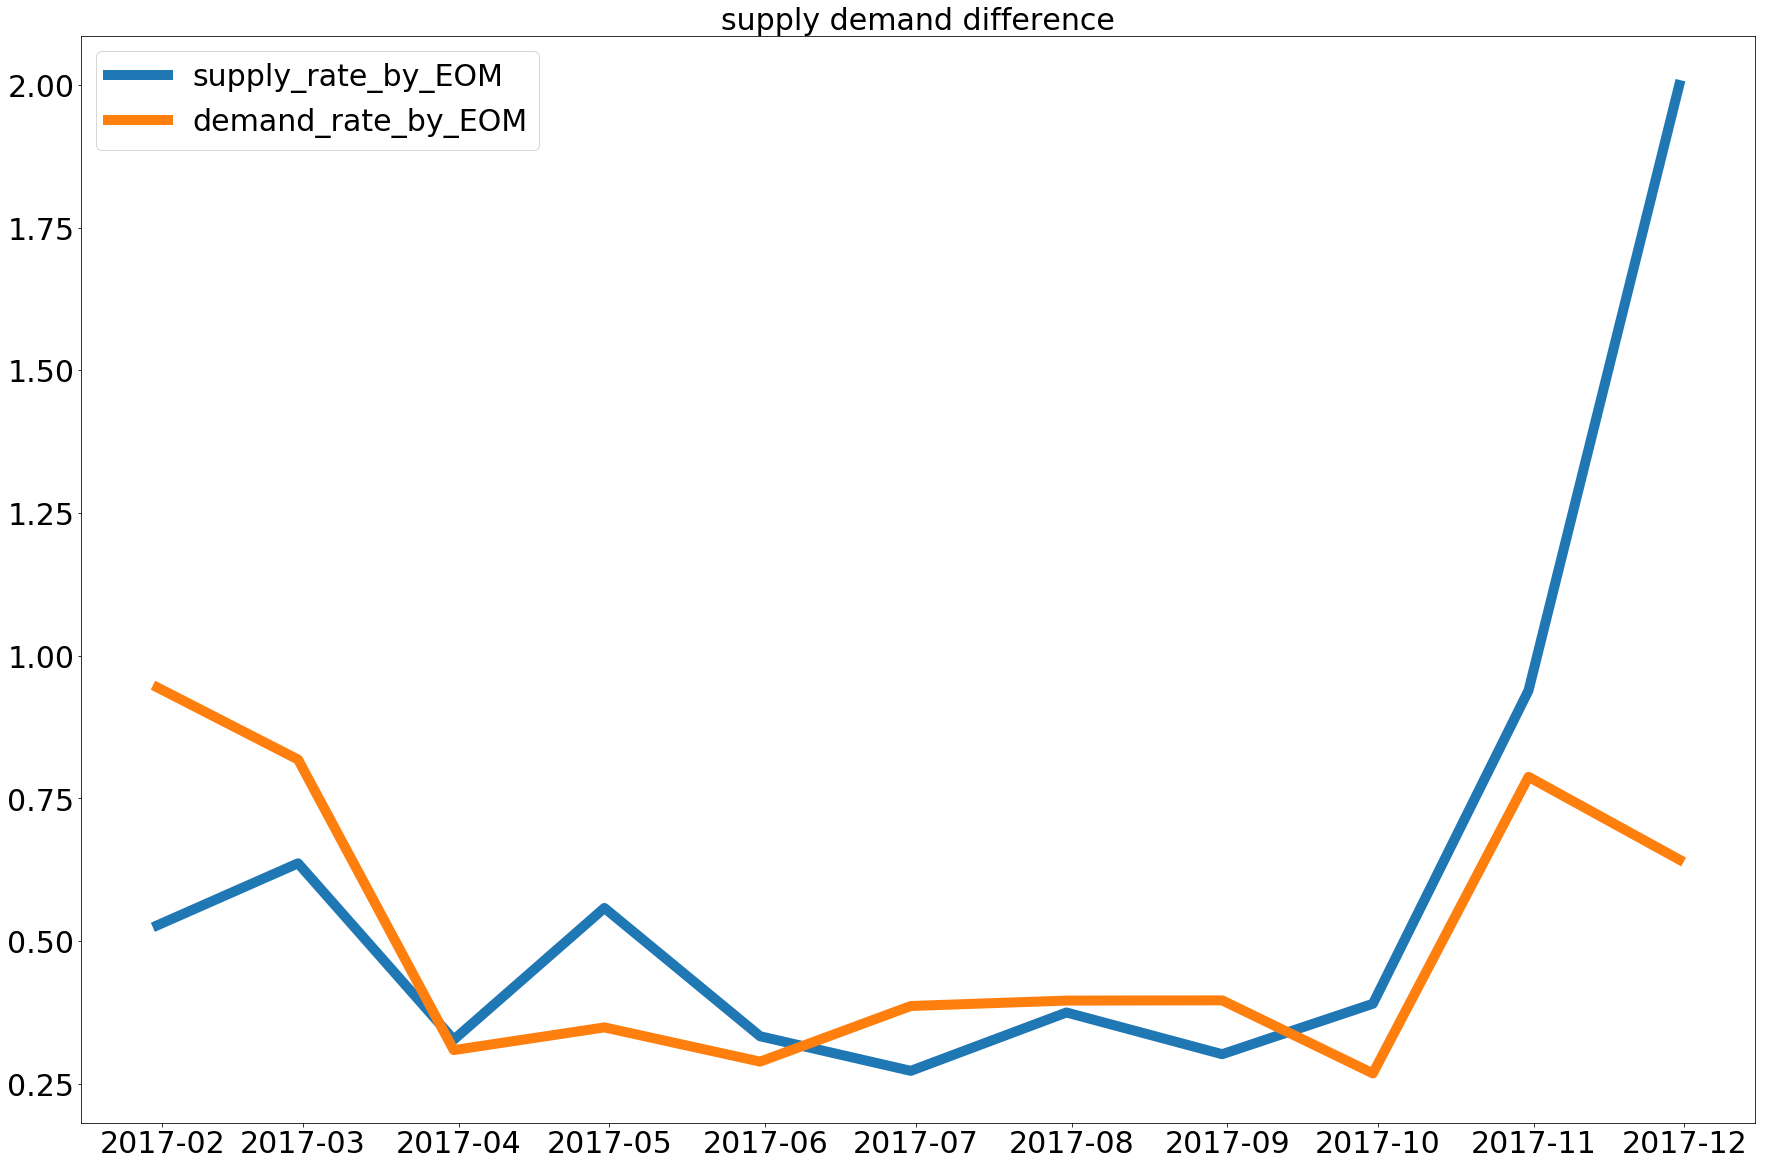

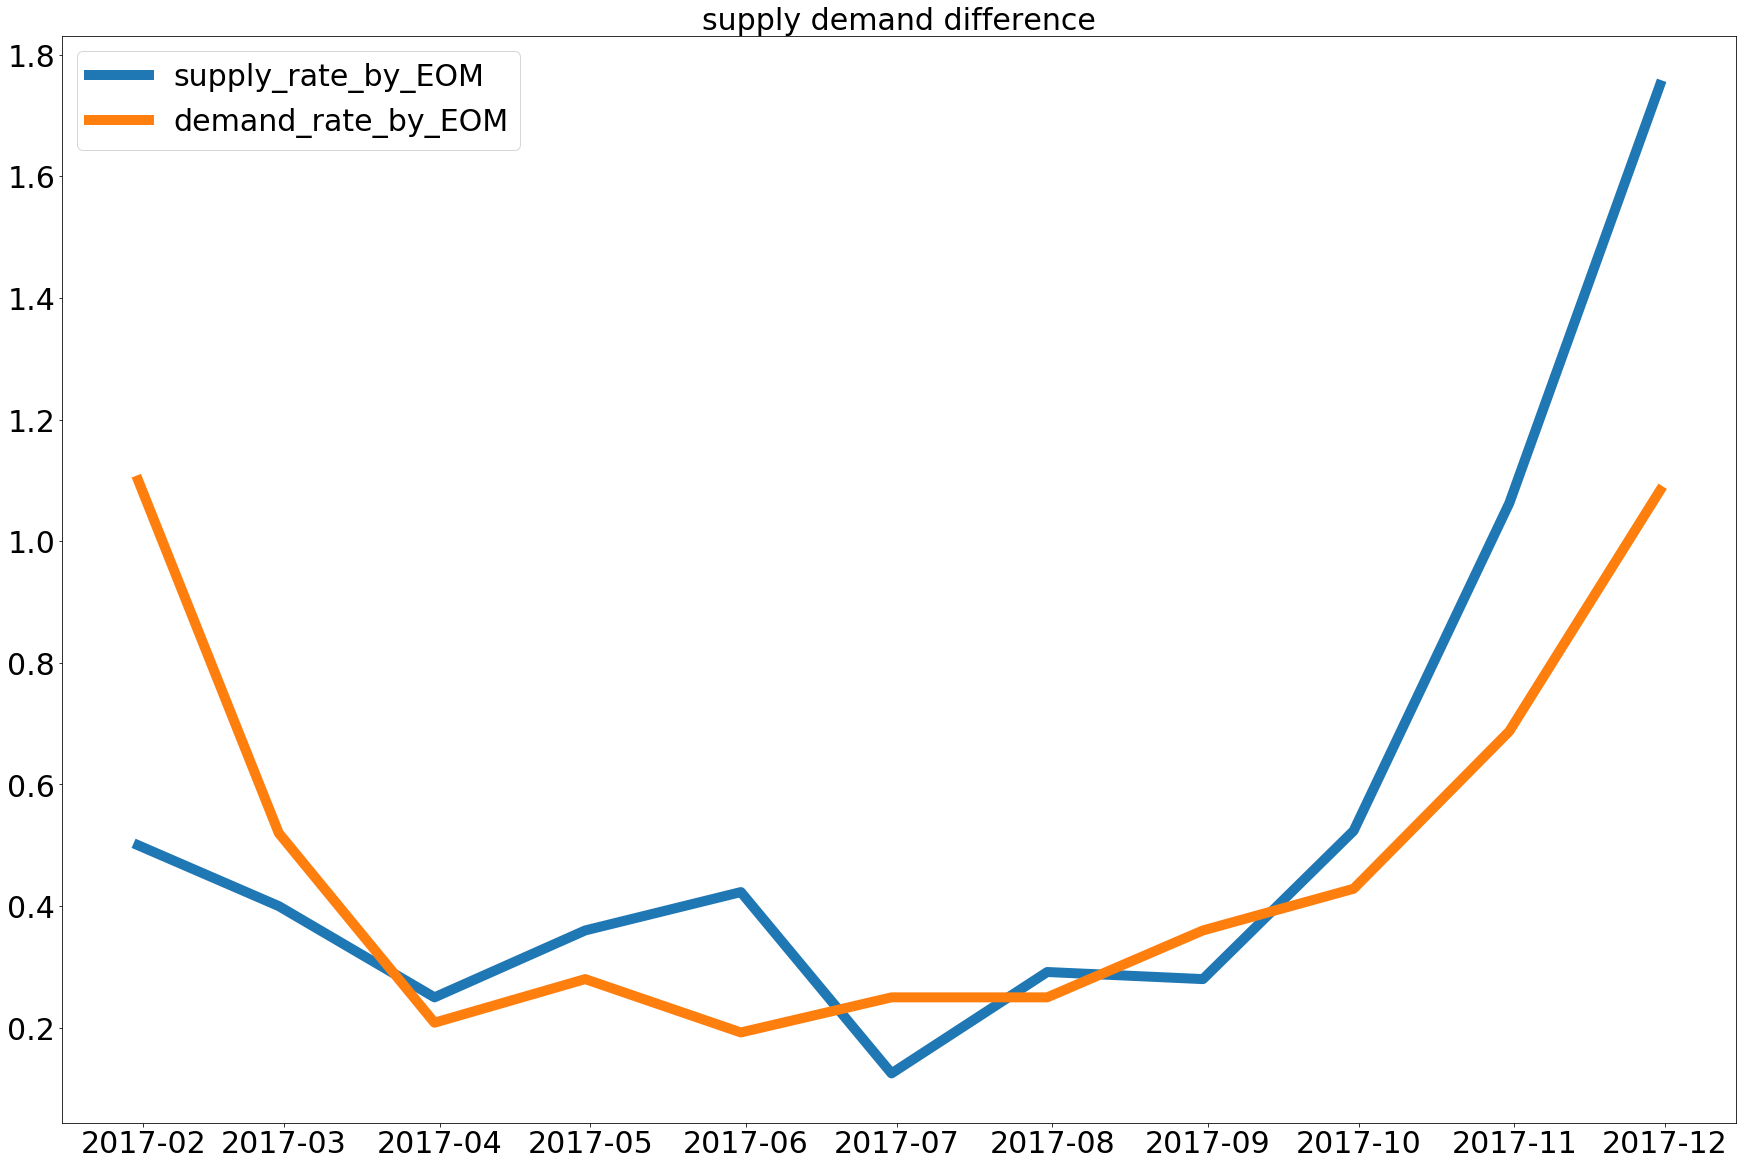

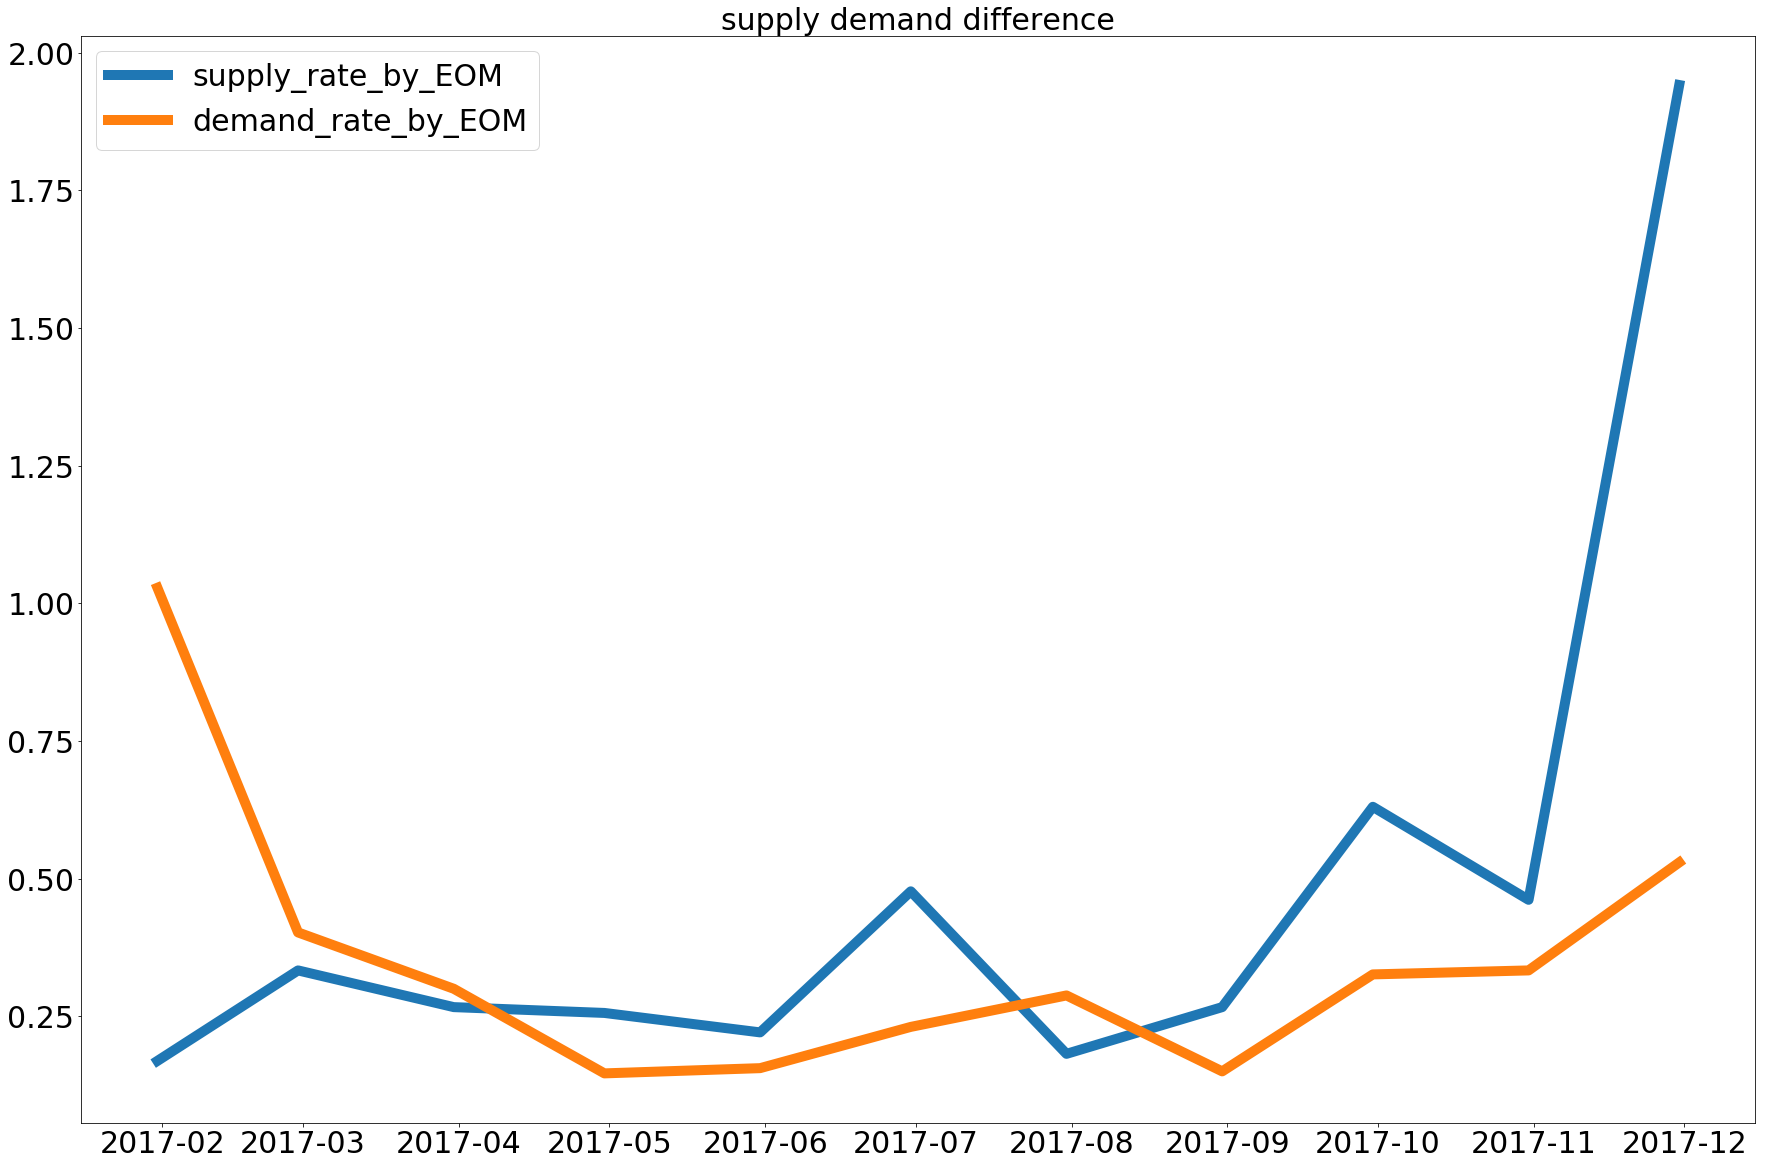

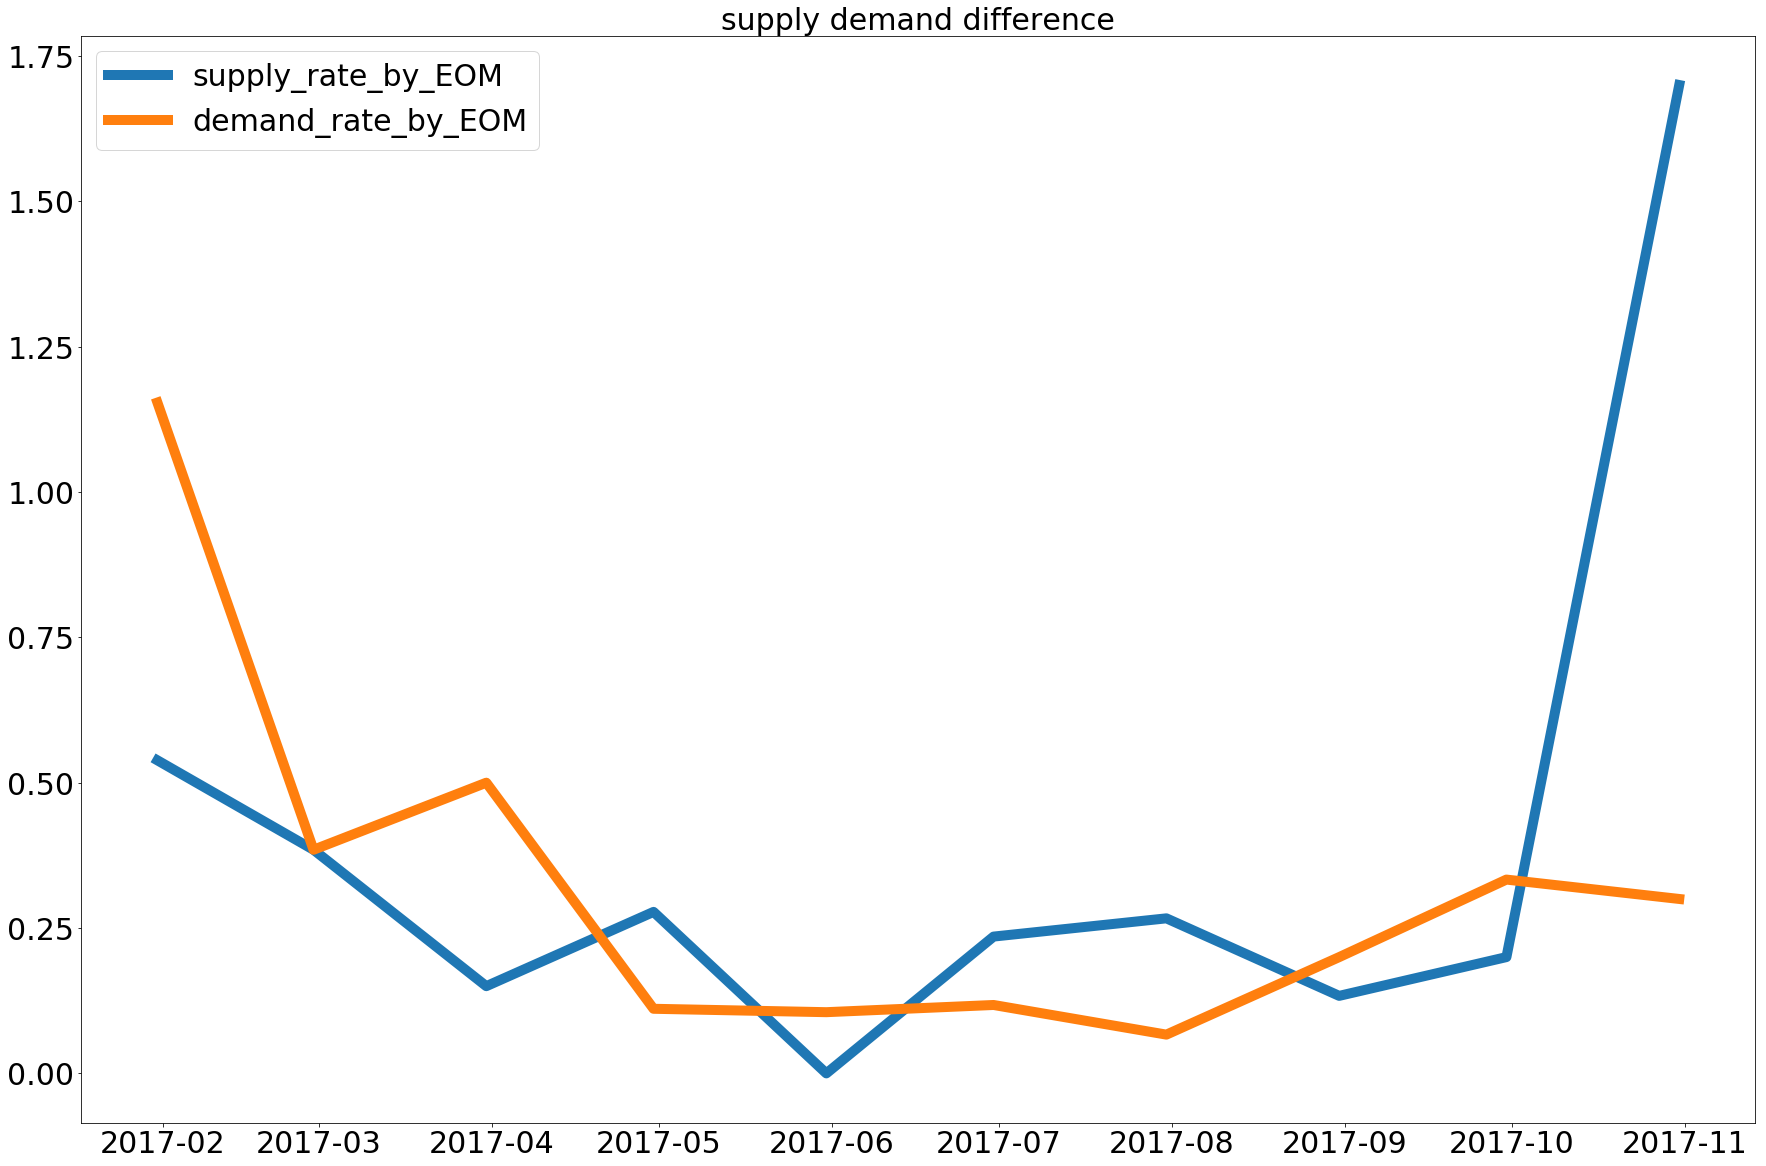

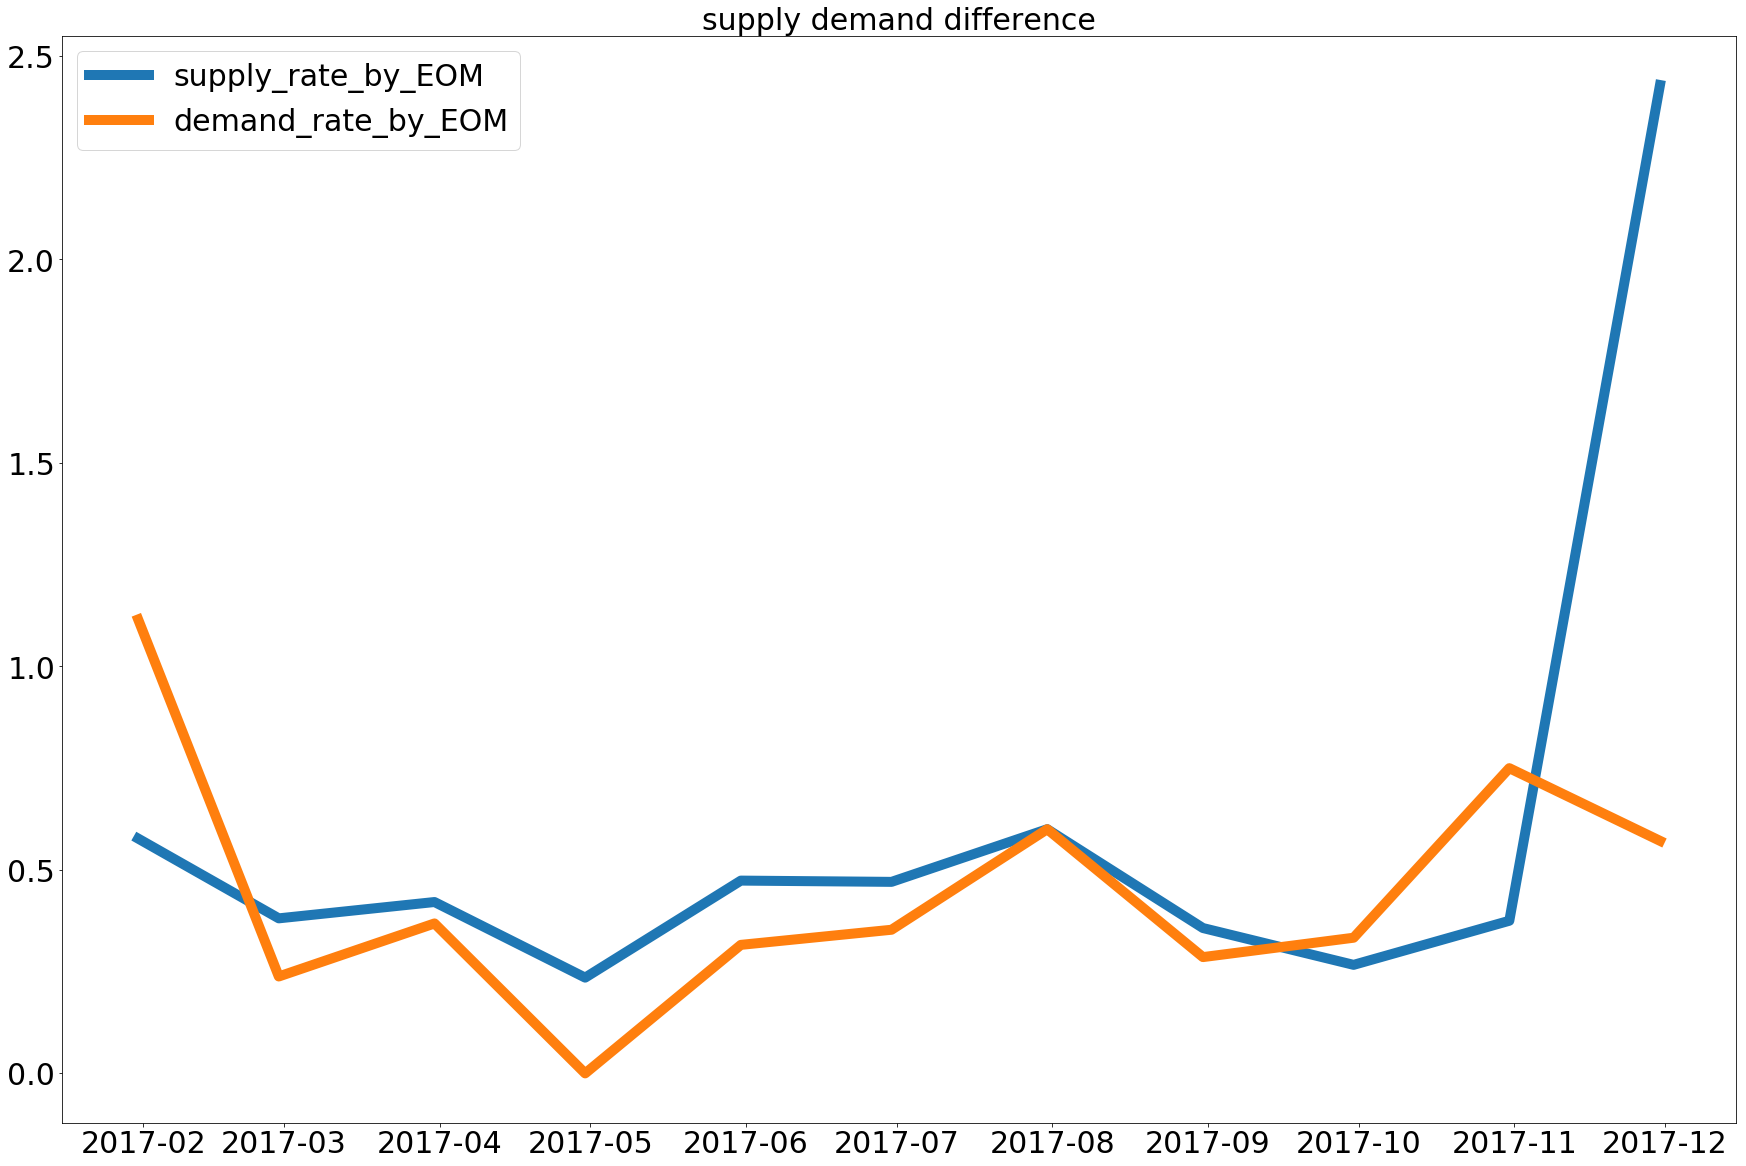

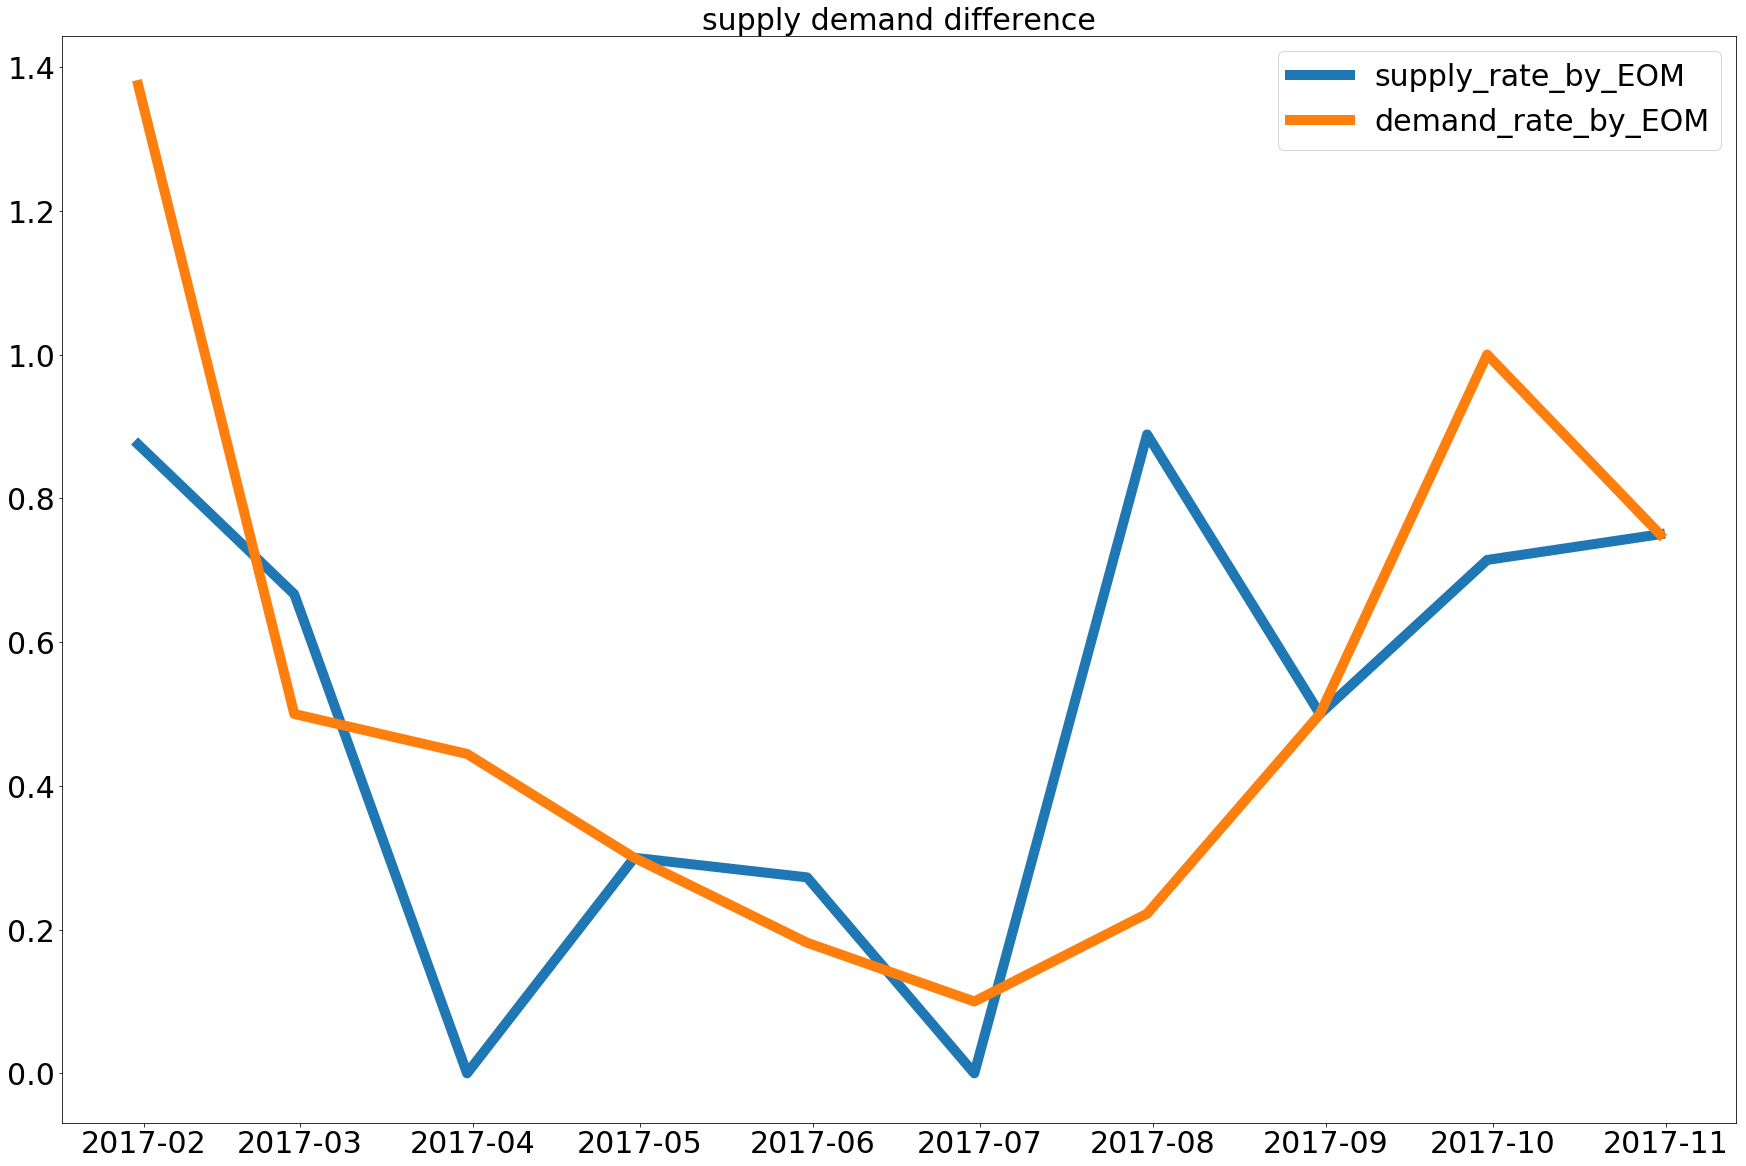

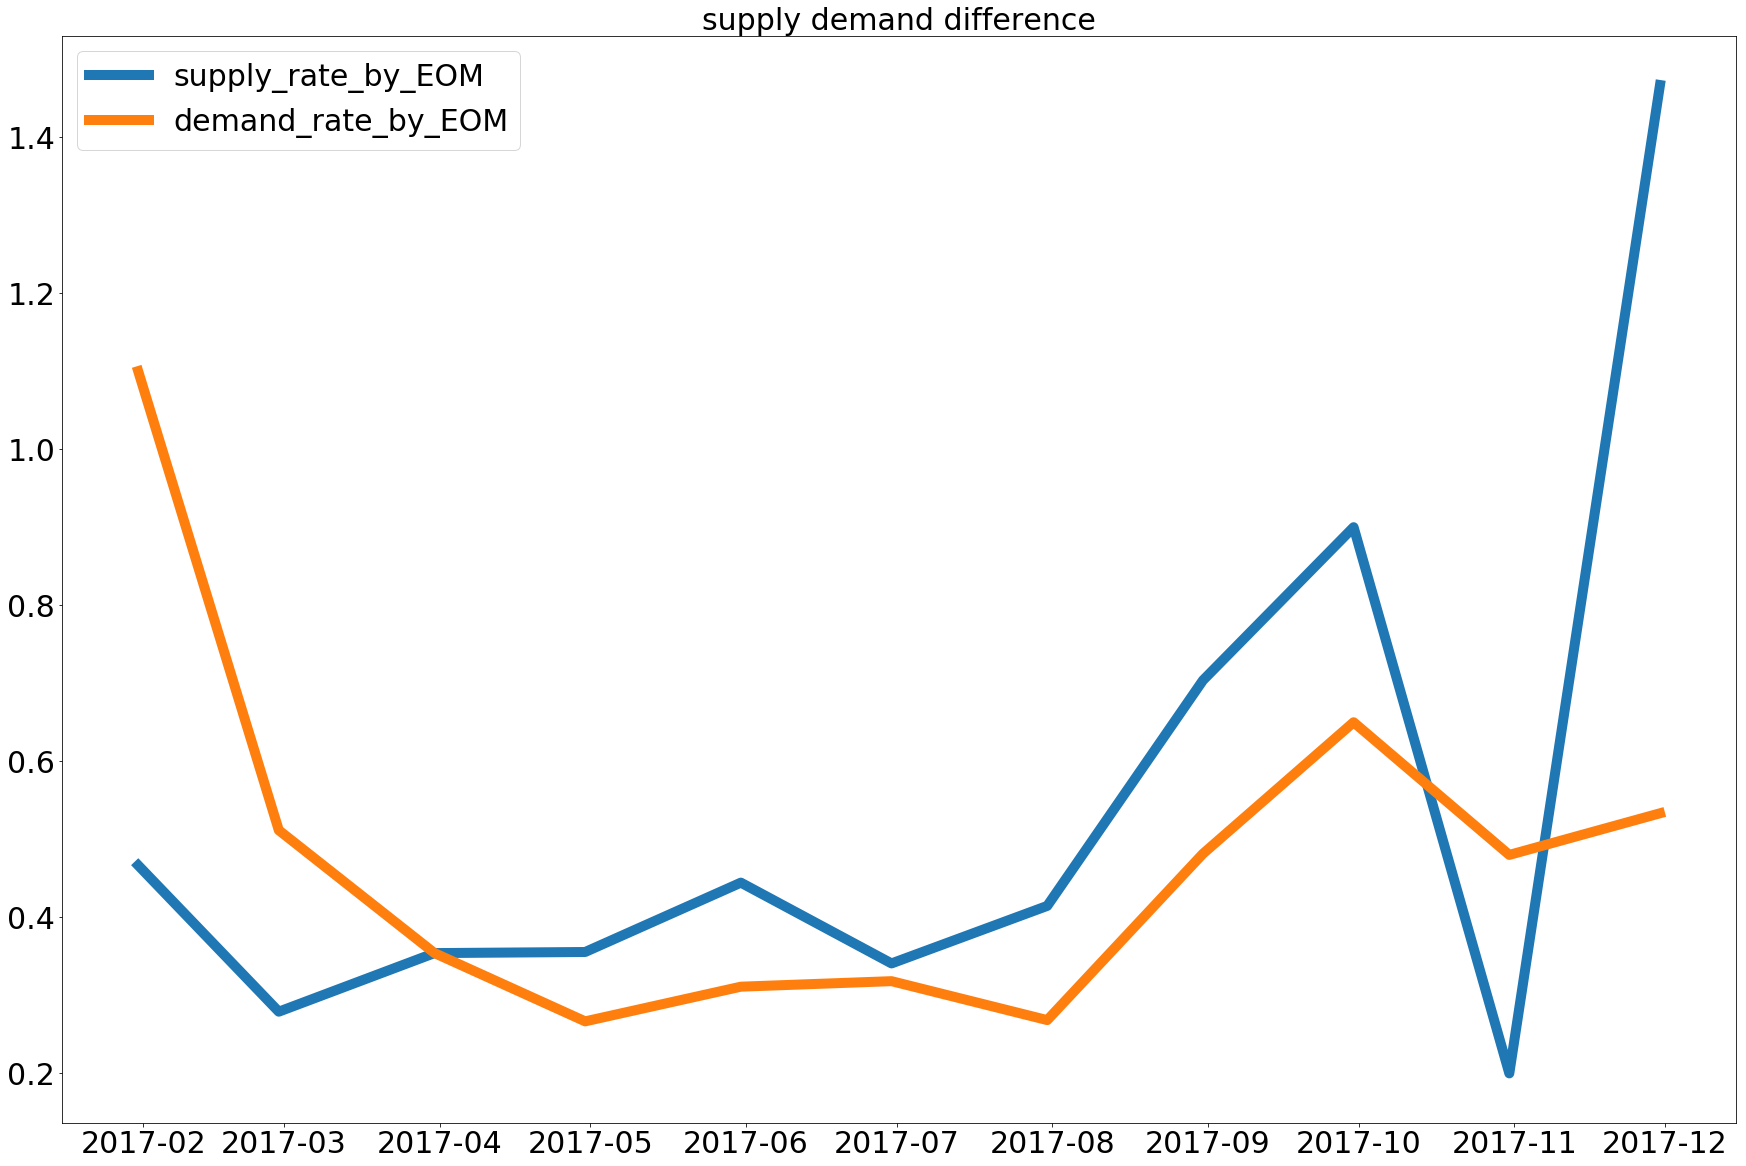

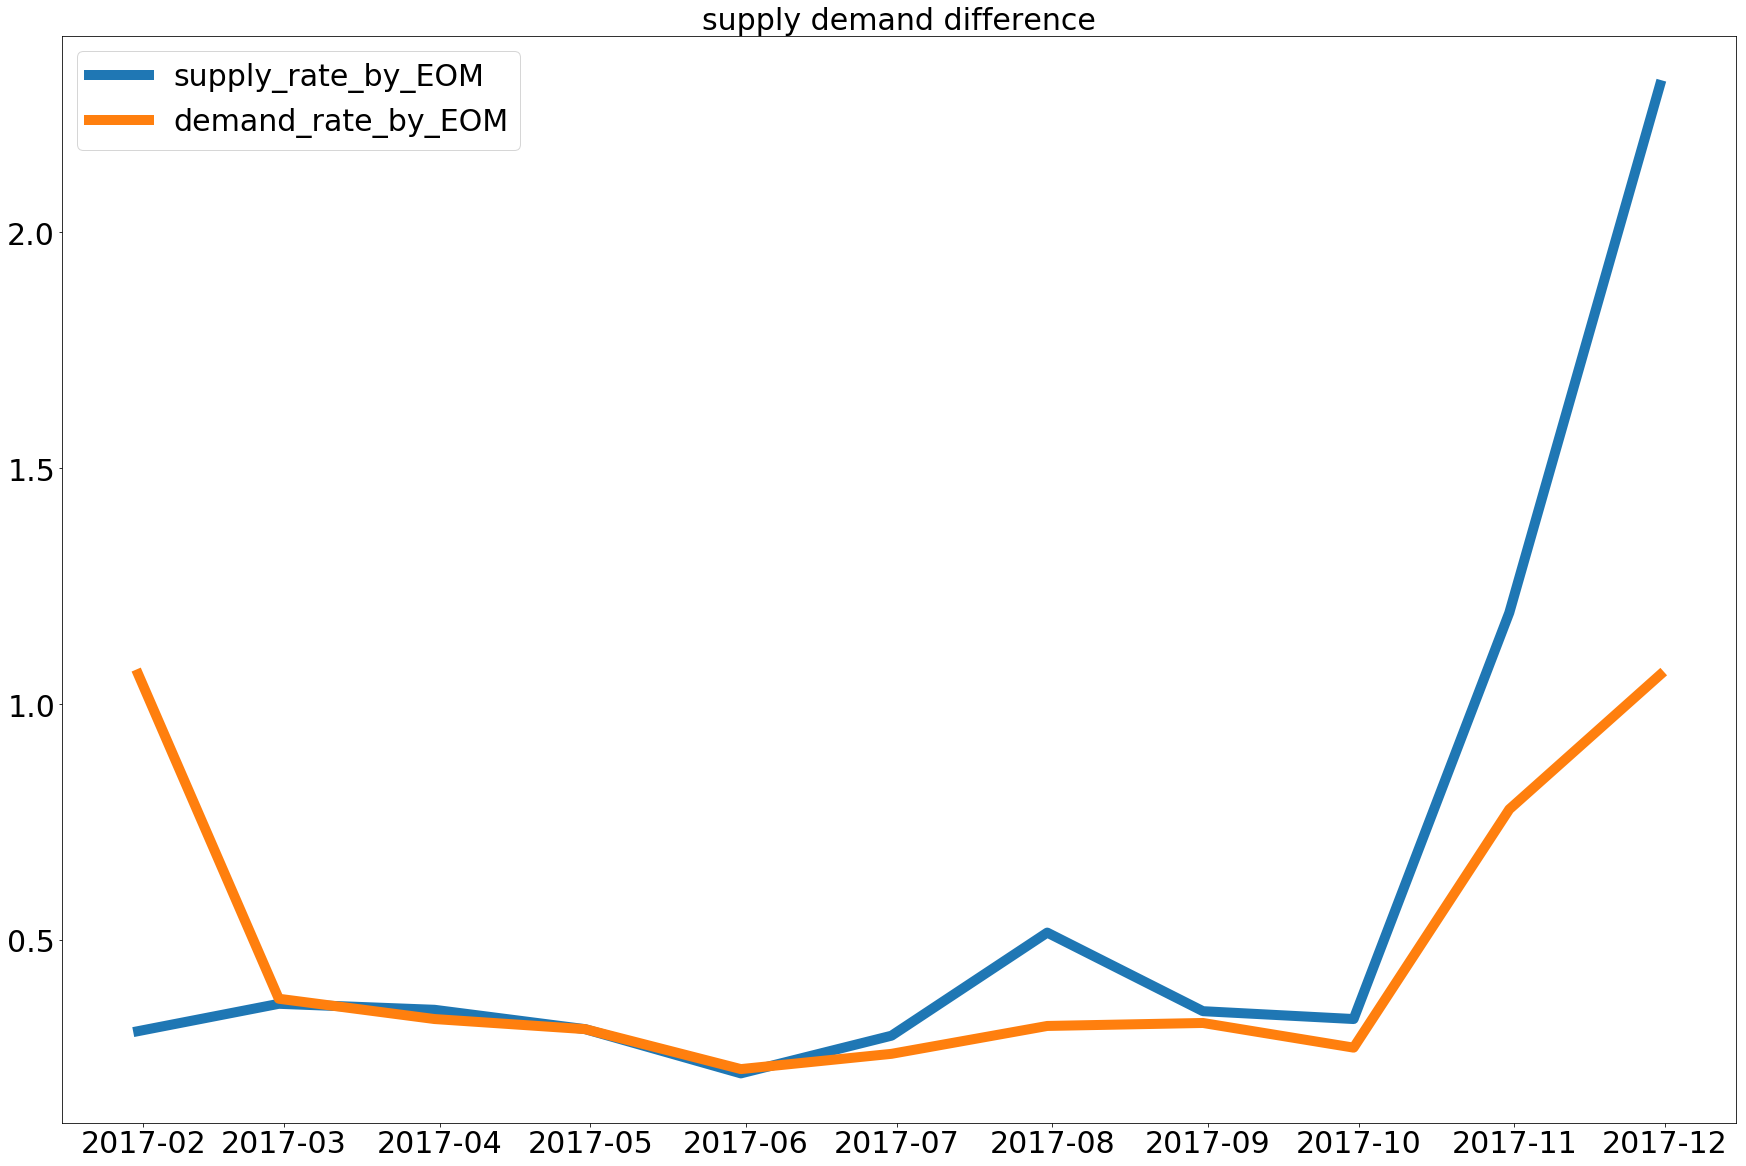

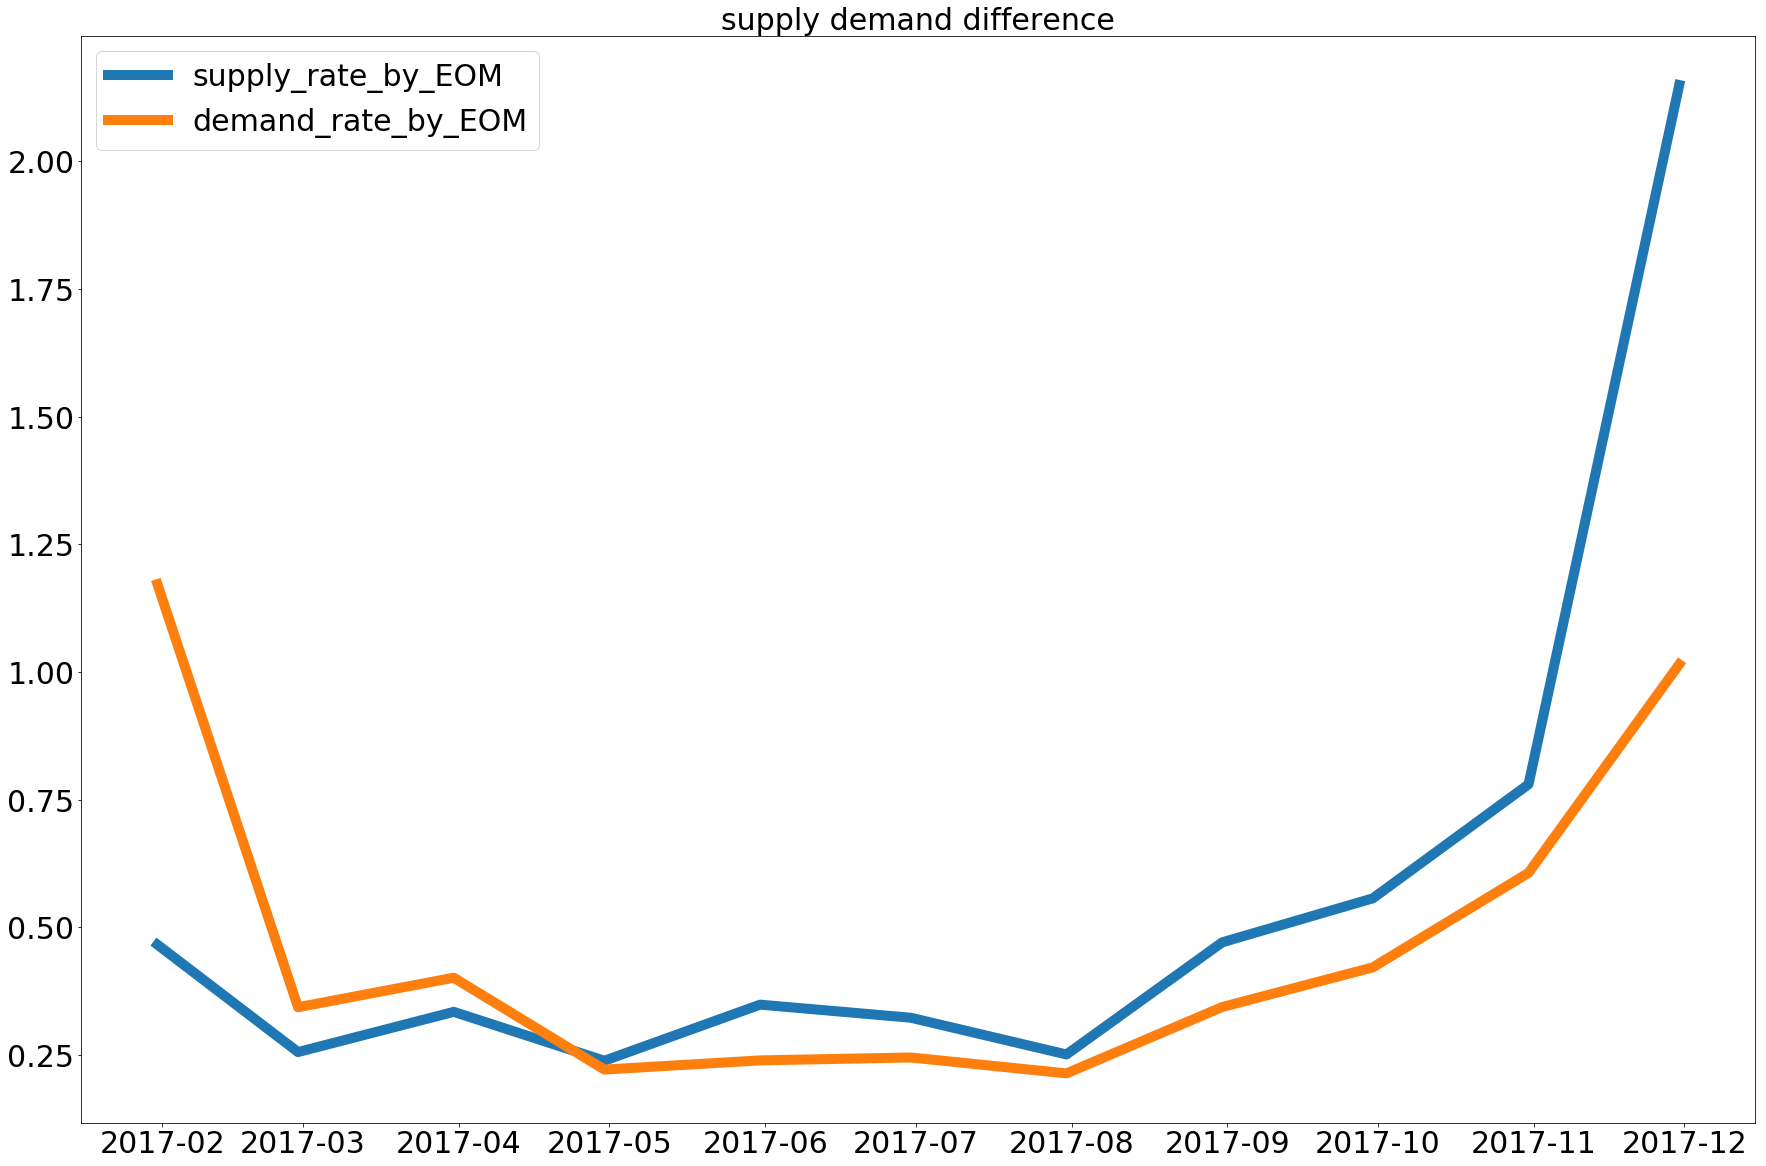

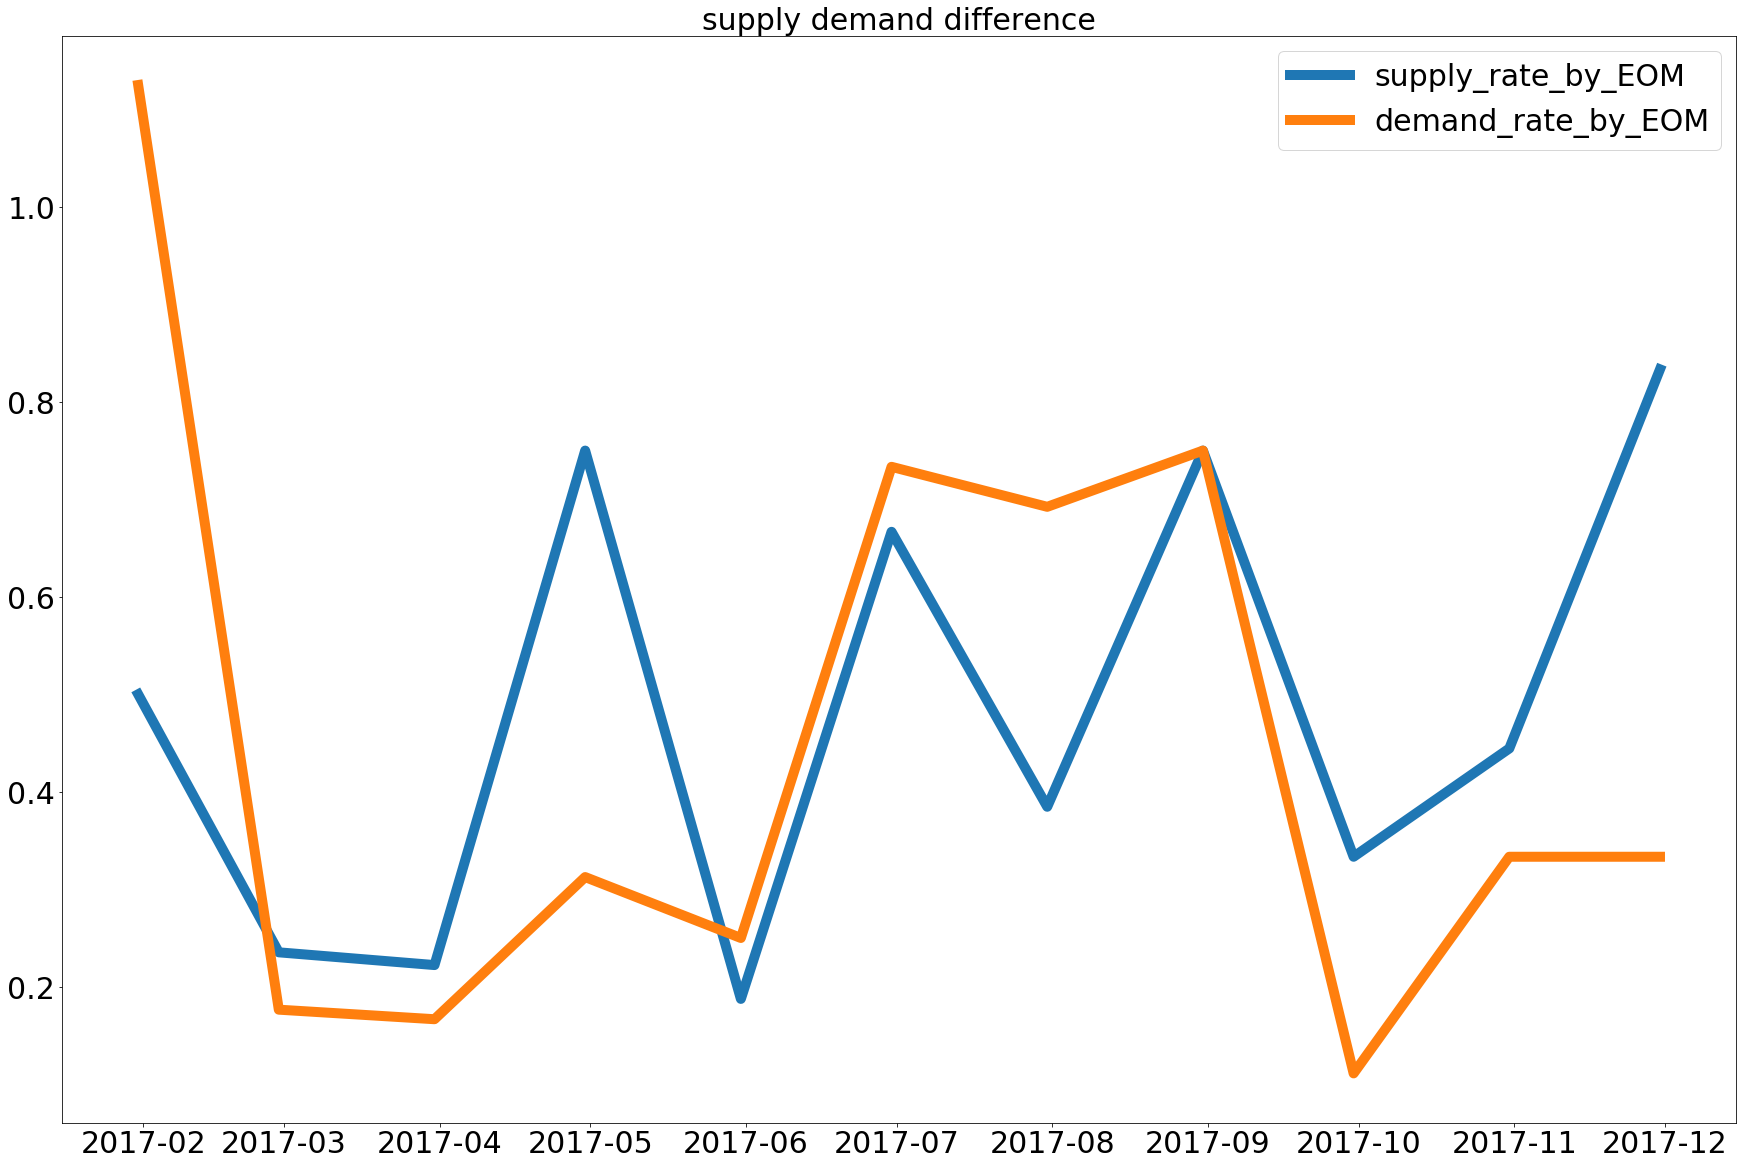

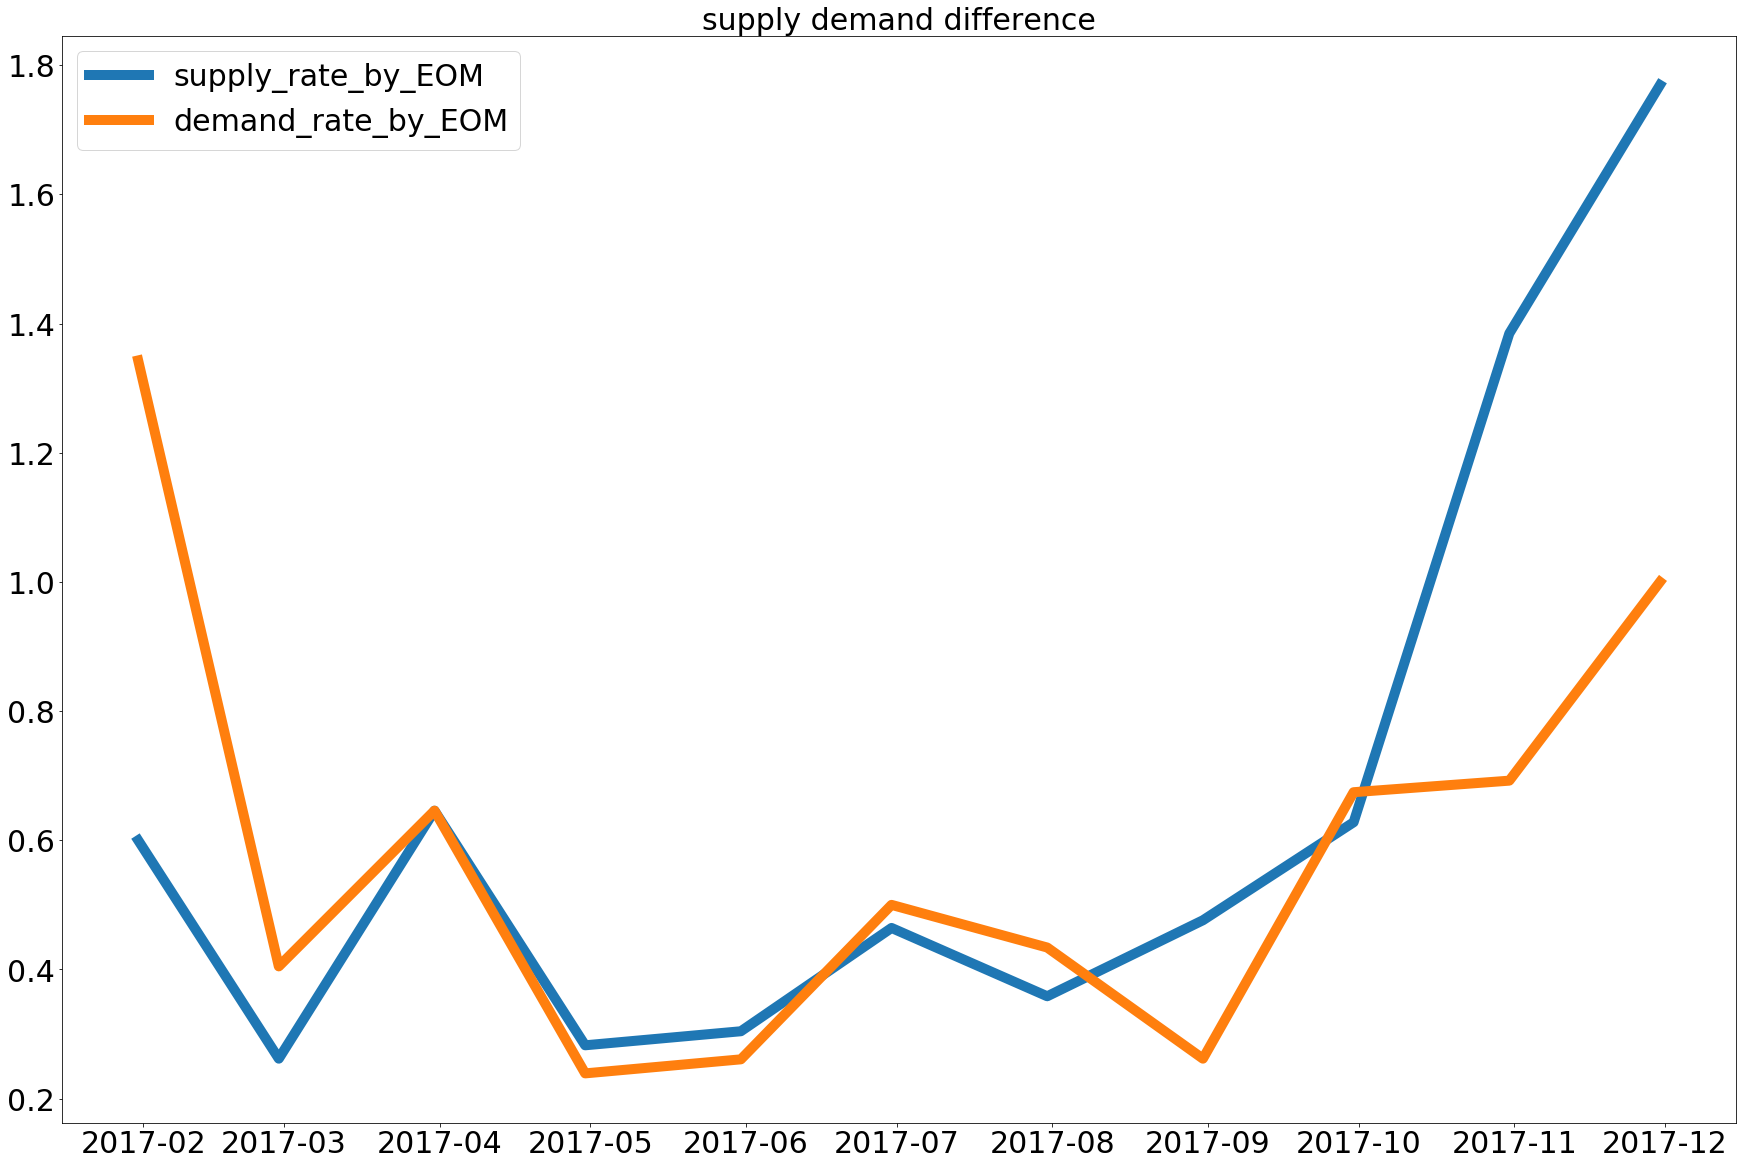

In [2]:
for t in range (1,26):
    # import data.
    data = pd.read_csv('industry_'+str(t)+'.csv')

    # set Id and rename columns
    # data = data.reset_index()
    data.columns = ['Id', 'Open_Date', 'Closed_Date']
    # Open date - date at which customer started their service
    # Clsoed date - date at which customer closed their service

    # convert to datetime data type
    data.Open_Date = pd.to_datetime(data.Open_Date)
    data.Closed_Date = pd.to_datetime(data.Closed_Date)

    # Start date and end date for churn_table
    start_date = data.Open_Date.min()
    end_date = data.Closed_Date.max()

    # For still active customers, temporarily set their closed date to be a month in the future for computation.
    data.Closed_Date = data.Closed_Date.fillna(end_date + datetime.timedelta(31))

    def month_diff(a, b):
        # calculate the difference in two dates in month
        return (a.year - b.year)* 12 + (a.month - b.month)

    def set_up_date():
        # set up date table
        end = []
        begin = []
        end_month=12
        for year in range(start_date.year+1, end_date.year+1):
            if year == end_date.year:
                end_month = end_date.month
            for month in range(1, end_month):
                begin.append(datetime.date(year, month, 1))
                if month == 12:
                    end.append(datetime.date(year+1, 1, 1) - datetime.timedelta(days = 1))
                else:
                    end.append(datetime.date(year, month+1, 1) - datetime.timedelta(days = 1))    
        date_table = pd.DataFrame([begin, end]).transpose()
        date_table.columns = ['begin', 'end']
        date_table['days'] = [(date_table.end[x] - date_table.begin[x]).days + 1 for x in range(len(date_table))]
        date_table.begin, date_table.end = pd.to_datetime(date_table.begin), pd.to_datetime(date_table.end)
        return date_table

    def get_churn_table():
        # Calculate Customer Churn
        churn =set_up_date()
        list_ = []
        for i in range(len(churn)):
            # Customers at the beginning of month
            id_beg = data.loc[(data['Open_Date'] <= churn.begin[i]) & (data['Closed_Date'] >= churn.begin[i]), 'Id']
            # Customers at the end of month
            id_end = data.loc[(data['Open_Date'] <= churn.end[i]) & (data['Closed_Date'] >= churn.end[i]), 'Id']   
            # Customers left during the month
            id_close =  data.loc[(data['Closed_Date'] >= churn.begin[i]) & (data['Closed_Date'] <= churn.end[i]), 'Id']
            # Customers left during the month (Those who were already customers before this month)
            id_beg_close = data.loc[(data.Id.isin(id_beg)) & (data.Id.isin(id_close)), 'Id']
            # Customers left during the month (Those who joined and left during the month)
            id_during = data.loc[(data['Closed_Date'] >= churn.begin[i]) & (data['Closed_Date'] <= churn.end[i])  & \
                                         (data['Open_Date'] >= churn.begin[i]) & (data['Open_Date'] <= churn.end[i]), 'Id']               
            # Customers joined during the month.
            id_app = data.loc[(data['Open_Date'] >= churn.begin[i]) & (data['Open_Date'] <= churn.end[i]), 'Id']

            # Calculate days between customer's start date and end of month (customers who started this month)
            if len(id_app)> 0:
                id_app_days = (churn.end[i] - data.loc[data.Id.isin(id_app), 'Open_Date']).sum().days
            else:
                id_app_days = 0

            # Calculate days between customer's closed date and end of month (customers who left this month)            
            if len(id_close)> 0:
                id_close_days = (churn.end[i] - data.loc[data.Id.isin(id_close), 'Closed_Date']).sum().days
            else:
                id_close_days = 0    

            # Sum of active customers in each day.
            total_days = churn.days[i]*len(data.loc[(data.Id.isin(id_beg)) & (data.Id.isin(id_close)==False), 'Id']) + \
                            id_app_days -  id_close_days
            list_.append((len(id_beg), len(id_end), len(id_close), len(id_beg_close), 
                          len(id_app), len(id_during), total_days))
        list_ = pd.DataFrame(list_)
        list_.columns = ['Customers_at_BOM', 'Customers_at_EOM', 'Customers_Lost', 'Customers_Lost_from_last_month',
                         'Customers_Added', 'Customers_within_month_churn', 'Total_Days']
        for col in list_.columns:
            list_[col] = list_[col].astype(float)
        churn = pd.concat([churn, list_], axis = 1)
        return churn    

    churn = get_churn_table()
    # churn['churn_rate_by_daily_rate'] = (churn.days*(churn.Customers_Lost/churn.Total_Days)).fillna(0)
    churn = churn.set_index(pd.DatetimeIndex(churn.end))
    churn['supply_rate_by_EOM'] = churn.Customers_Lost/churn.Customers_at_EOM
    churn['demand_rate_by_EOM'] = churn.Customers_Added/churn.Customers_at_EOM

    plt.figure(figsize = (30, 20))
    for col in ['supply_rate_by_EOM','demand_rate_by_EOM']:
        plt.plot(churn[col], linewidth=10)
    plt.legend(prop={'size':30})
    plt.title('supply demand difference', size=30)
    plt.tick_params(labelsize=30)
    plt.savefig('industry_'+str(t)+'.png')